## Setup

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
!nvidia-smi

Tue Apr 29 02:56:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   44C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


### Imports

In [4]:
import torch
import torchvision
import os
import requests
import json
from PIL import Image, ImageOps, ImageDraw
from torchvision import transforms
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import cv2

In [5]:
# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14') # Loading the Large DINO Backbone/feature extractor

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:04<00:00, 254MB/s]


In [7]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [8]:
def visualize_image_mask_overlay(image_path, mask):
    """
    Visualize the binary mask overlaid on the original image.

    Args:
        image_path (str): Path to the original image.
        mask (np.ndarray): Binary mask of the same size as the image.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    # Overlay the mask on the image
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5, cmap="jet")  # Use transparency for the mask
    plt.title("Image with Mask Overlay")
    plt.axis("off")

    plt.show()

In [9]:
def visualize_mask(image_path, mask):
    """
    Visualize the masked part as transparent and the non-masked part as black.

    Args:
        image_path (str): Path to the original image.
        mask (np.ndarray): Binary mask of the same size as the image.
    """
    from matplotlib.colors import to_rgba

    # Load the image
    image = Image.open(image_path).convert("RGBA")  # Use RGBA for transparency
    image = np.array(image)  # Convert to NumPy array

    # Create a copy for applying transparency
    transparent_image = np.zeros_like(image)
    transparent_image[:, :, 3] = 255  # Set alpha channel to fully opaque by default

    # Mask logic: non-masked parts (where mask == 0) become black
    transparent_image[mask == 0, :3] = [0, 0, 0]  # Set RGB to black for non-masked areas
    transparent_image[mask == 0, 3] = 255         # Set alpha to fully opaque for non-masked

    # Masked part remains as transparent (alpha = 0)
    transparent_image[mask > 0, 3] = 0            # Set alpha to fully transparent for masked areas

    # Display the results
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path).convert("RGB"))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(transparent_image)
    plt.title("Masked Transparent Image")
    plt.axis("off")

    plt.show()

In [10]:
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(image_path, gt_bbox):
    """
    Visualizes the bounding box on an image using the AP-10K format.

    Parameters:
    - image_path (str): Path to the image file.
    - gt_bbox (list): Bounding box in AP-10K format [x_min, y_min, width, height].
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

    # Extract bbox parameters
    x_min, y_min, width, height = gt_bbox

    # Draw the bounding box
    cv2.rectangle(image, (x_min, y_min), (x_min + width, y_min + height), color=(255, 0, 0), thickness=2)

    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Bounding Box Visualization")
    plt.show()

In [11]:
def parse_flattened_keypoints(keypoints_list, num_keypoints):
    """
    Parse flattened keypoints list into list of (x, y, visibility) tuples.

    Args:
    - keypoints_list (list): Flattened list of keypoint coordinates
    - num_keypoints (int): Number of keypoints

    Returns:
    - list: List of (x, y, visibility)
    """
    parsed_keypoints = []
    for i in range(num_keypoints):
        # Each keypoint is represented by 3 values: x, y, visibility
        start_idx = i * 3
        x = keypoints_list[start_idx]
        y = keypoints_list[start_idx + 1]
        visibility = keypoints_list[start_idx + 2]
        parsed_keypoints.append((x, y, visibility))

    return parsed_keypoints


In [12]:
# Add this function to draw keypoints on the image
def draw_keypoints(image, keypoints, radius=7, color='purple'):
    """
    Draw keypoints on the given image.

    Args:
    - image (PIL.Image): Input image
    - keypoints (list): List of keypoint coordinates [(x1, y1), (x2, y2), ...]
    - radius (int): Radius of keypoint circles
    - color (str): Color of keypoints

    Returns:
    - PIL.Image: Image with keypoints drawn
    """
    # Create a copy of the image to draw on
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # Draw each keypoint
    for kp in keypoints:
        x, y, visibility = kp
        # Draw a filled circle for each present keypoint
        if visibility > 0:  # 1 or 2 indicates present
          draw.ellipse([x-radius, y-radius, x+radius, y+radius], fill=color)

    return draw_image

In [21]:
import numpy as np
from PIL import Image, ImageDraw

def draw_skeleton_transformed(
    image,                    # PIL Image: The FINAL image (after crop, resize, padding) to draw on
    original_keypoints,       # Flat list [x1, y1, v1, ...] in ORIGINAL image coords
    num_keypoints,            # Number of keypoints
    crop_origin,              # Tuple (x_min, y_min) of the crop box start in original coords
    original_crop_size,       # Tuple (width, height) of the cropped image BEFORE resize
    resize_scale,             # Tuple (scale_x, scale_y) resize factors
    padding_offset,           # Tuple (left_pad, top_pad) padding added
    radius=4,                 # Radius of keypoint circles
    keypoint_color='purple',  # Color of keypoints
    skeleton_color='purple'   # Color of skeleton lines
):
    """
    Draws keypoints and skeleton lines on the final image after applying transformations.

    Args:
    - image (PIL.Image): The FINAL image (after crop, resize, padding) to draw on.
    - original_keypoints (list): Flat list [x1, y1, v1, ...] in ORIGINAL image coordinates.
    - num_keypoints (int): Total number of keypoints.
    - crop_origin (tuple): (x_min, y_min) of the crop box in original image coords.
    - original_crop_size (tuple): (width, height) of the image AFTER cropping, BEFORE resize.
    - resize_scale (tuple): (scale_x, scale_y) factors used for resizing.
    - padding_offset (tuple): (left_pad, top_pad) added to the resized image.
    - radius (int): Radius of keypoint circles.
    - keypoint_color (str): Color of keypoints.
    - skeleton_color (str): Color of skeleton lines.

    Returns:
    - PIL.Image: Image with transformed keypoints and skeleton drawn.
    """
    # --- Transformation Parameters ---
    x_min, y_min = crop_origin
    orig_crop_w, orig_crop_h = original_crop_size
    scale_x, scale_y = resize_scale
    left_pad, top_pad = padding_offset
    final_h, final_w = image.height, image.width # Get dimensions from the final image

    # --- Transform Keypoints ---
    transformed_keypoints = [] # List to store (x_final, y_final, visibility) tuples
    for i in range(num_keypoints):
        x_orig = original_keypoints[i*3]
        y_orig = original_keypoints[i*3 + 1]
        visibility = original_keypoints[i*3 + 2]

        x_final_int, y_final_int = -1, -1 # Default invalid coords

        # Only process visible keypoints (or potentially all for structure, but draw based on visibility)
        # Let's transform all, but only draw visible ones later
        # 1. Adjust for Crop
        x_cropped = x_orig - x_min
        y_cropped = y_orig - y_min

        # Check if keypoint was outside the crop area
        if not (0 <= x_cropped < orig_crop_w and 0 <= y_cropped < orig_crop_h):
             # Store invalid coords but keep visibility to maintain list structure
             transformed_keypoints.append((x_final_int, y_final_int, visibility))
             continue # Skip rest of transformation for this keypoint

        # 2. Adjust for Resize
        x_resized = x_cropped * scale_x
        y_resized = y_cropped * scale_y

        # 3. Adjust for Padding
        x_final = x_resized + left_pad
        y_final = y_resized + top_pad

        # Round to integer coordinates for drawing
        x_final_int = int(round(x_final))
        y_final_int = int(round(y_final))

        # Store transformed coords and original visibility
        transformed_keypoints.append((x_final_int, y_final_int, visibility))

    # --- Draw on Image ---
    draw_image = image.copy()
    draw = ImageDraw.Draw(draw_image)

    # AP10K skeleton connections (assuming 1-based indexing in definition)
    skeleton_connections = [
        (1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (6, 7), (7, 8),
        (4, 9), (9, 10), (10, 11), (5, 12), (12, 13), (13, 14), (5, 15),
        (15, 16), (16, 17)
    ]

    # Draw skeleton lines using TRANSFORMED keypoints
    for start_node, end_node in skeleton_connections:
        start_idx, end_idx = start_node - 1, end_node - 1 # Adjust to 0-based index

        if 0 <= start_idx < len(transformed_keypoints) and 0 <= end_idx < len(transformed_keypoints):
            x_start, y_start, vis_start = transformed_keypoints[start_idx]
            x_end, y_end, vis_end = transformed_keypoints[end_idx]

            # Draw line only if BOTH keypoints are visible (vis == 2) and within final image bounds
            if (vis_start == 2 and vis_end == 2 and
                0 <= x_start < final_w and 0 <= y_start < final_h and
                0 <= x_end < final_w and 0 <= y_end < final_h):
                start_point = (x_start, y_start)
                end_point = (x_end, y_end)
                draw.line([start_point, end_point], fill=skeleton_color, width=4) # Use width=4 as in original

    # Draw TRANSFORMED keypoints
    for i in range(len(transformed_keypoints)):
        x_final, y_final, visibility = transformed_keypoints[i]

        # Draw only visible keypoints (visibility == 2) that are within the final image bounds
        if visibility == 2 and 0 <= x_final < final_w and 0 <= y_final < final_h:
            # Draw a filled circle for each keypoint
            draw.ellipse(
                [x_final - radius, y_final - radius, x_final + radius, y_final + radius],
                fill=keypoint_color
            )

    return draw_image


In [14]:
def create_keypoint_mask_transform_inside(
    final_image_shape,
    original_keypoints,
    num_keypoints,
    crop_origin,         # (x_min, y_min) of the crop box in original image coords
    original_crop_size,  # (width, height) of the image AFTER cropping, BEFORE resize
    resize_scale,        # (scale_x, scale_y) factors used for resizing
    padding_offset       # (left_pad, top_pad) added to the resized image
):
    """
    Creates a mask based on original keypoints, applying transformations internally.

    Args:
    - final_image_shape: (height, width) of the FINAL padded image.
    - original_keypoints: Flat list [x1, y1, v1, ...] in ORIGINAL image coords.
    - num_keypoints: Number of keypoints.
    - crop_origin: Tuple (x_min, y_min) of the crop box start.
    - original_crop_size: Tuple (width, height) of the cropped image before resize.
    - resize_scale: Tuple (scale_x, scale_y) resize factors.
    - padding_offset: Tuple (left_pad, top_pad) padding added.

    Returns:
    - Numpy boolean mask for the final image.
    """
    mask = np.zeros(final_image_shape[:2], dtype=np.uint8)
    x_min, y_min = crop_origin
    orig_crop_w, orig_crop_h = original_crop_size
    scale_x, scale_y = resize_scale
    left_pad, top_pad = padding_offset

    for i in range(num_keypoints):
        x_orig = original_keypoints[i*3]
        y_orig = original_keypoints[i*3 + 1]
        visibility = original_keypoints[i*3 + 2]

        # Only process visible keypoints
        if visibility == 2:
            # --- Apply Transformations ---
            # 1. Adjust for Crop
            x_cropped = x_orig - x_min
            y_cropped = y_orig - y_min

            # Check if keypoint was outside the crop area after adjusting origin
            # (Technically, points outside bbox shouldn't exist in good annotations, but good practice)
            if not (0 <= x_cropped < orig_crop_w and 0 <= y_cropped < orig_crop_h):
                 continue # Skip keypoints that were outside the crop region

            # 2. Adjust for Resize
            x_resized = x_cropped * scale_x
            y_resized = y_cropped * scale_y

            # 3. Adjust for Padding
            x_final = x_resized + left_pad
            y_final = y_resized + top_pad

            # --- Draw Circle on Mask ---
            # Ensure coordinates are integers and within final image bounds
            final_h, final_w = final_image_shape[:2]
            x_final_int = int(round(x_final))
            y_final_int = int(round(y_final))

            # Draw only if the final point is within the mask dimensions
            if 0 <= x_final_int < final_w and 0 <= y_final_int < final_h:
                 cv2.circle(mask, (x_final_int, y_final_int), radius=20, color=255, thickness=-1)

    # No dilation, return boolean mask
    return mask > 0

In [15]:
transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )])


transform1 = transforms.Compose([
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

# Transform image for CLIP
clip_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])  # CLIP normalization
])

{1: 'antelope', 2: 'argali sheep', 3: 'bison', 4: 'buffalo', 5: 'cow', 6: 'sheep', 7: 'arctic fox', 8: 'dog', 9: 'fox', 10: 'wolf', 11: 'beaver', 12: 'alouatta', 13: 'monkey', 14: 'noisy night monkey', 15: 'spider monkey', 16: 'uakari', 17: 'deer', 18: 'moose', 19: 'hamster', 20: 'elephant', 21: 'horse', 22: 'zebra', 23: 'bobcat', 24: 'cat', 25: 'cheetah', 26: 'jaguar', 27: 'king cheetah', 28: 'leopard', 29: 'lion', 30: 'panther', 31: 'snow leopard', 32: 'tiger', 33: 'giraffe', 34: 'hippo', 35: 'chimpanzee', 36: 'gorilla', 37: 'orangutan', 38: 'rabbit', 39: 'skunk', 40: 'mouse', 41: 'rat', 42: 'otter', 43: 'weasel', 44: 'raccoon', 45: 'rhino', 46: 'marmot', 47: 'squirrel', 48: 'pig', 49: 'mole', 50: 'black bear', 51: 'brown bear', 52: 'panda', 53: 'polar bear', 54: 'bat'}
First image for jaguar with size (840, 840)


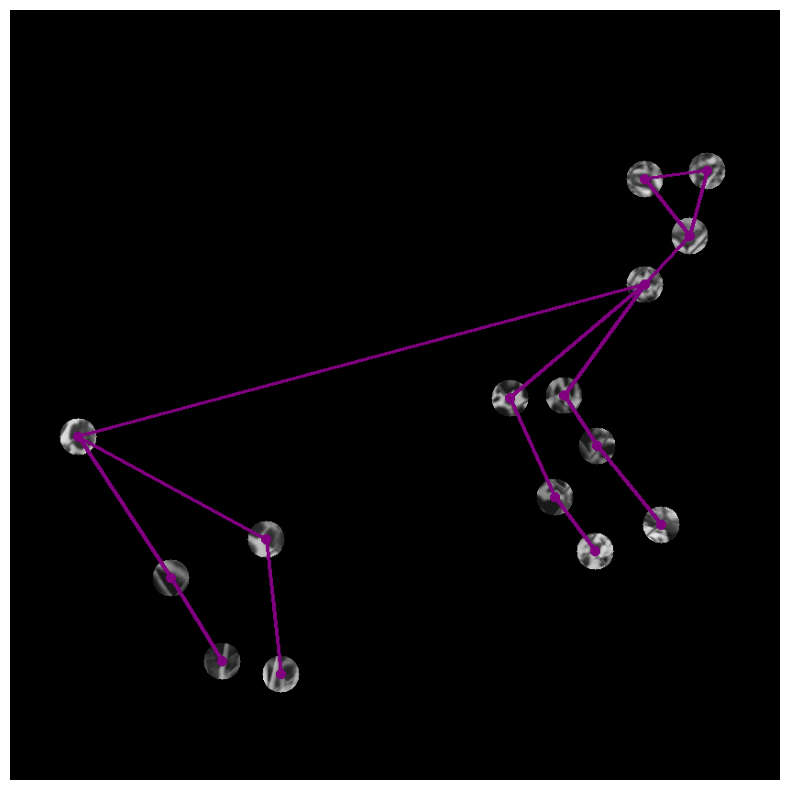

First image for leopard with size (840, 840)


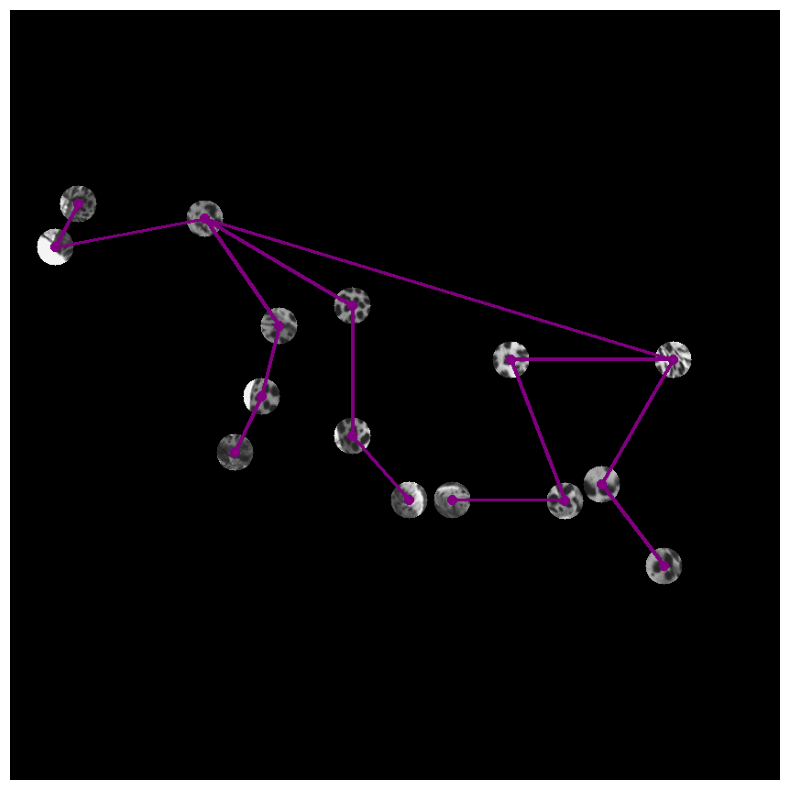

Have Generated Features for 100 Images.
First image for cat with size (840, 840)


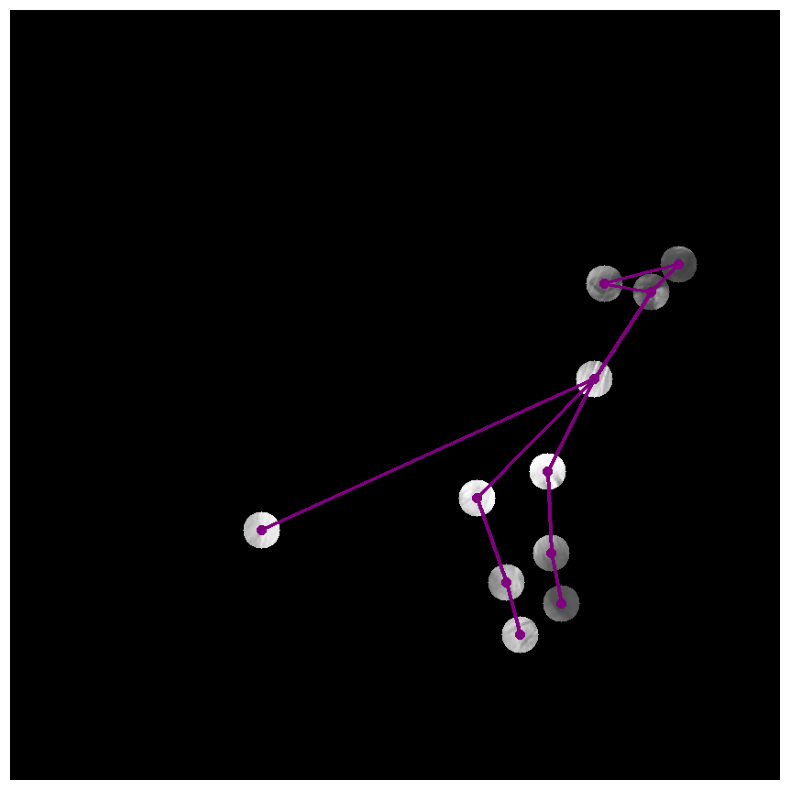

First image for tiger with size (840, 840)


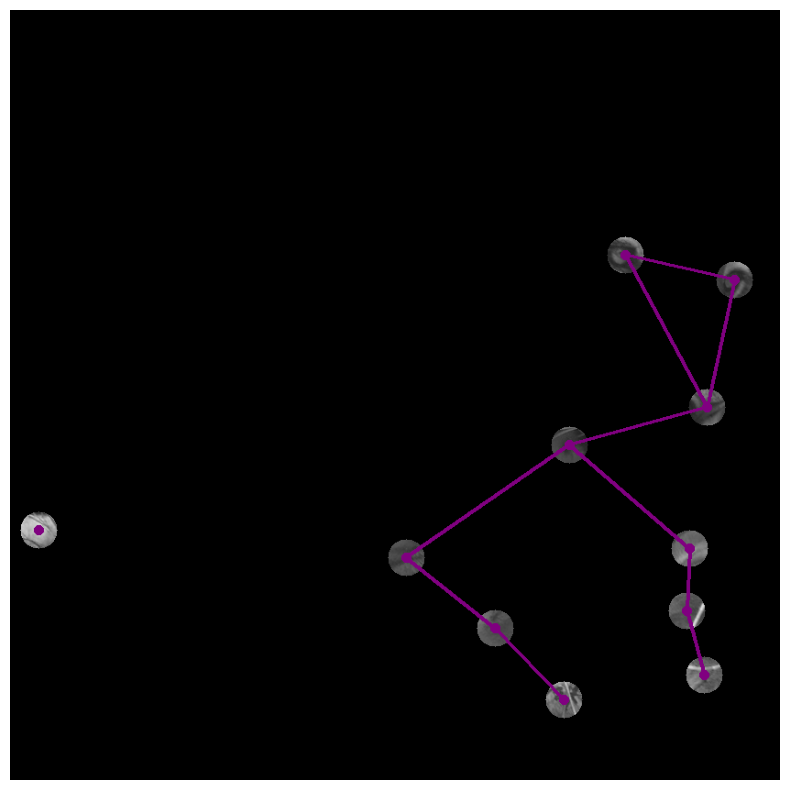

First image for giraffe with size (840, 840)


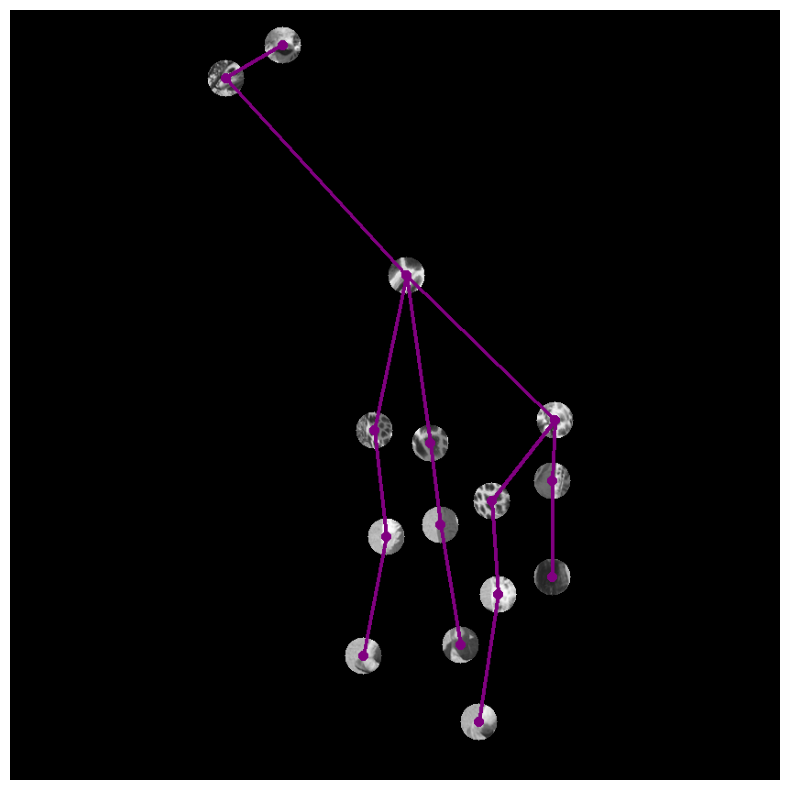

Have Generated Features for 200 Images.
First image for hippo with size (840, 840)


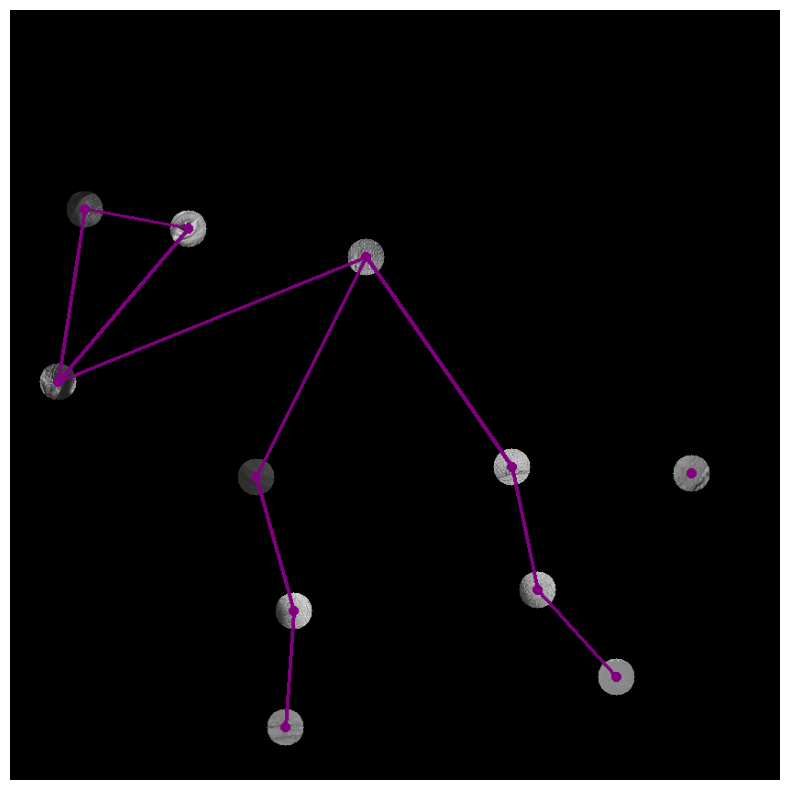

First image for chimpanzee with size (840, 840)


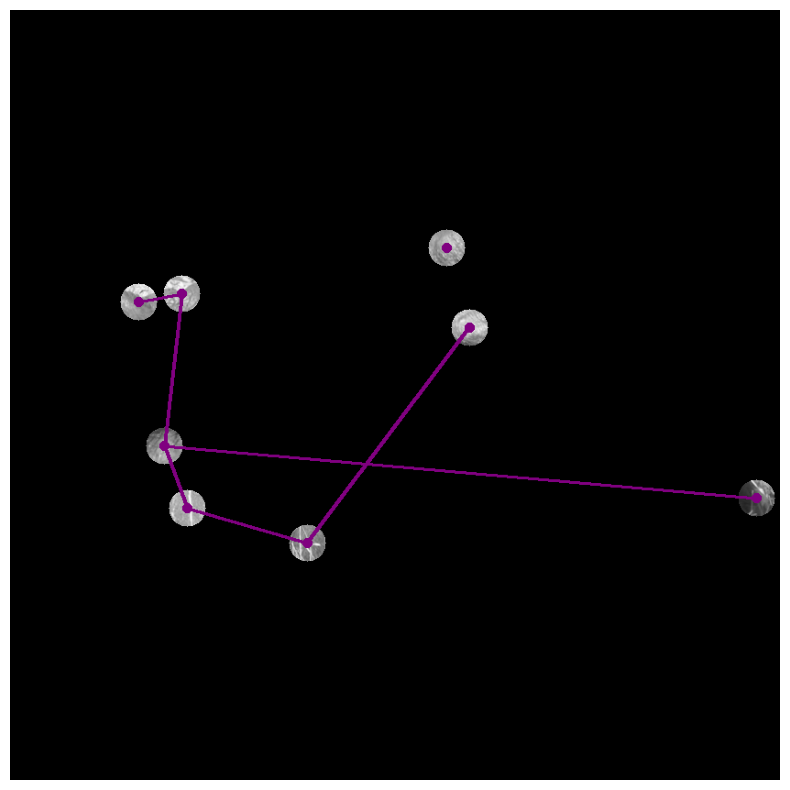

Have Generated Features for 300 Images.
First image for rabbit with size (840, 840)


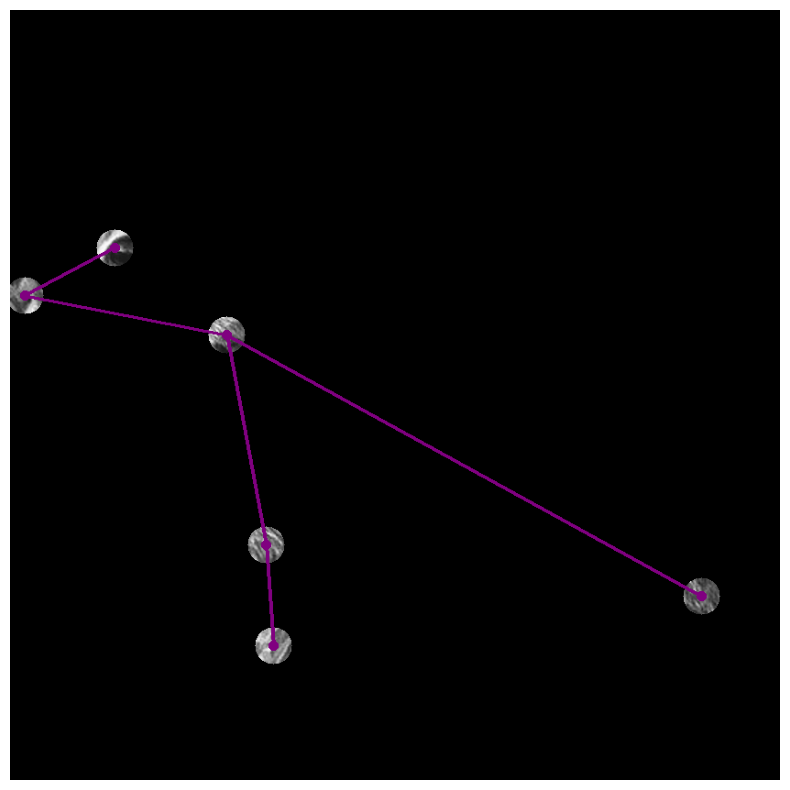

First image for skunk with size (840, 840)


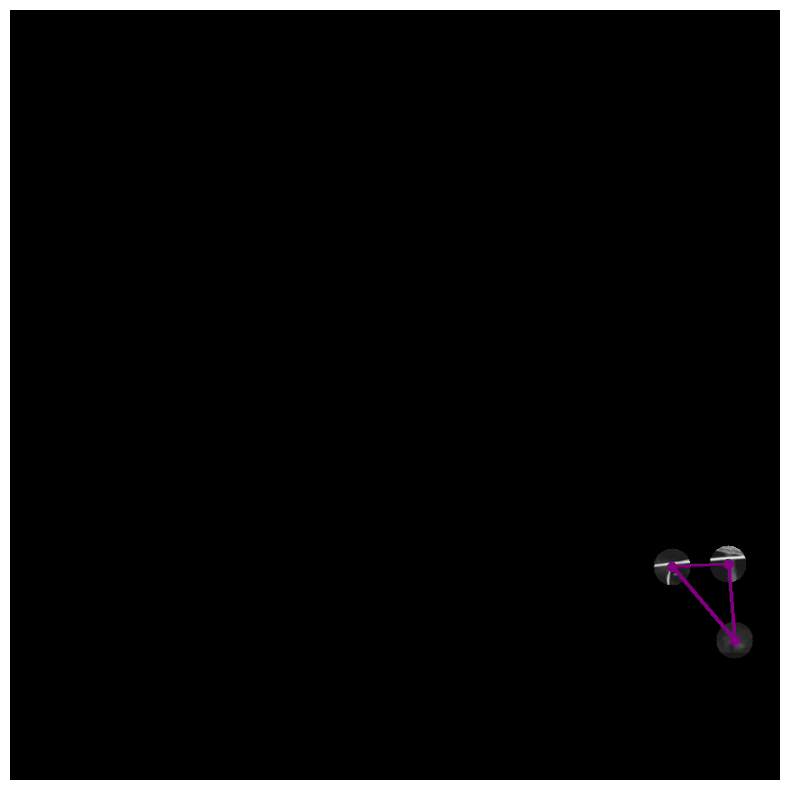

Have Generated Features for 400 Images.
First image for mouse with size (840, 840)


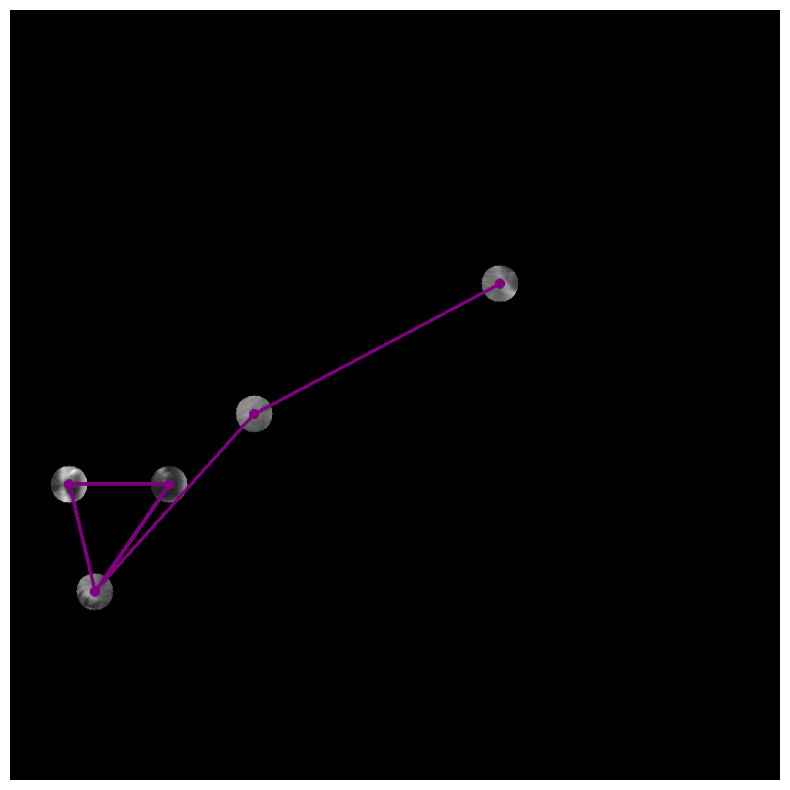

First image for rat with size (840, 840)


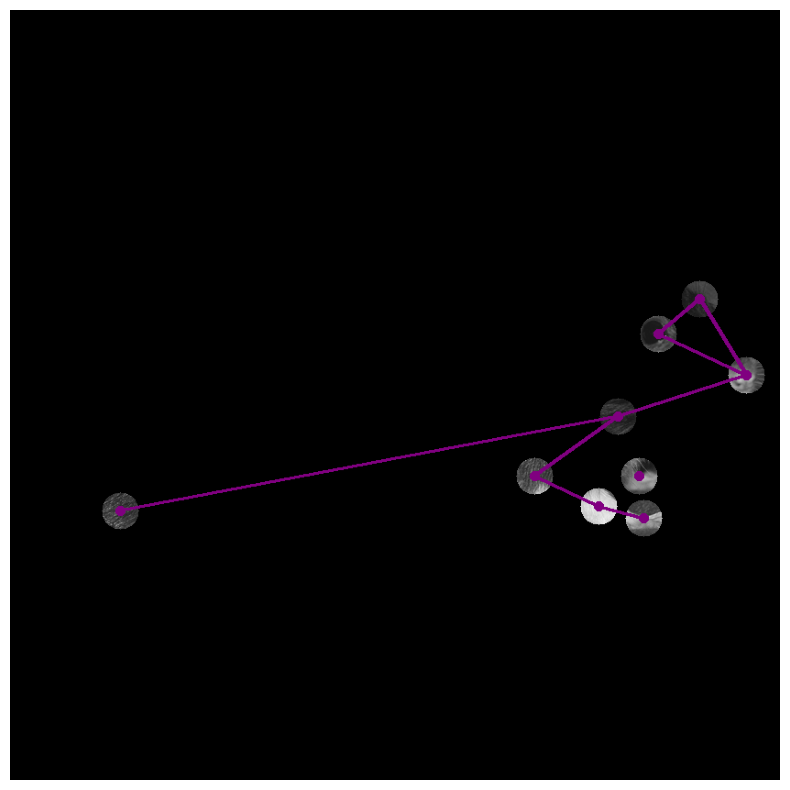

First image for otter with size (840, 840)


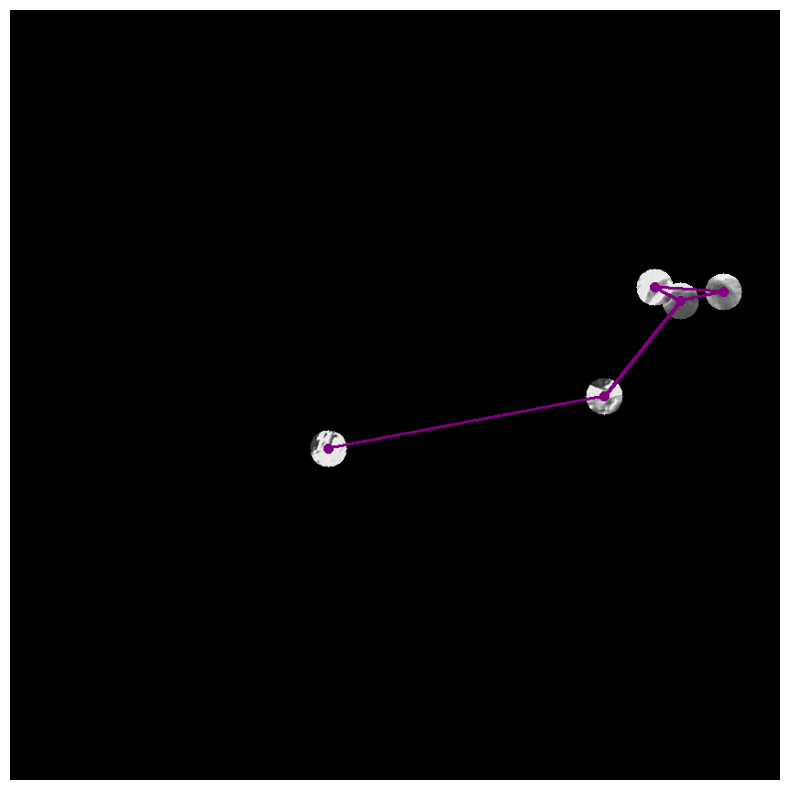

First image for weasel with size (840, 840)


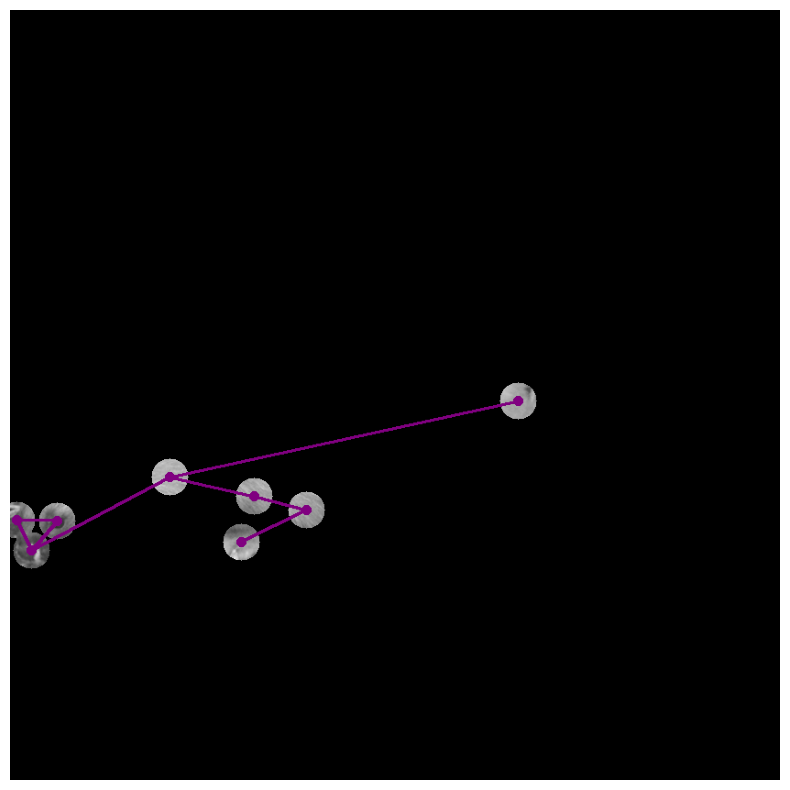

First image for raccoon with size (840, 840)


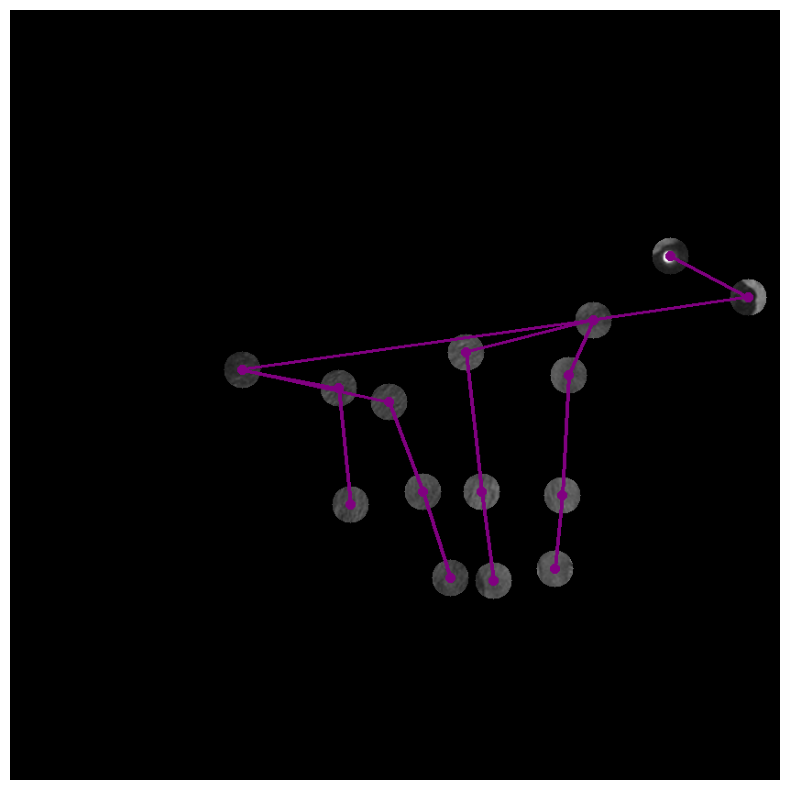

Have Generated Features for 500 Images.
First image for rhino with size (840, 840)


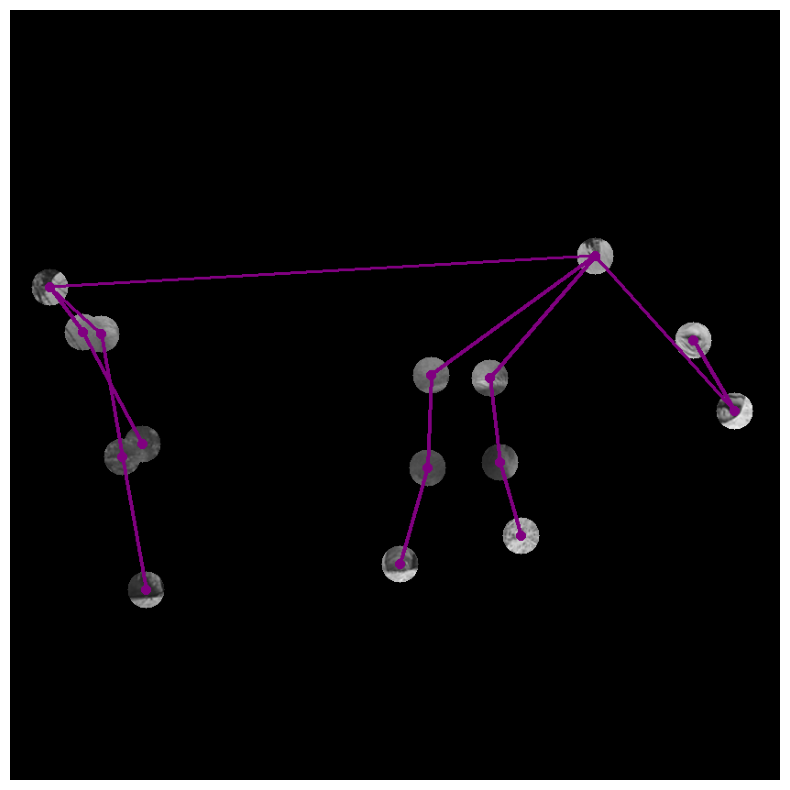

First image for squirrel with size (840, 840)


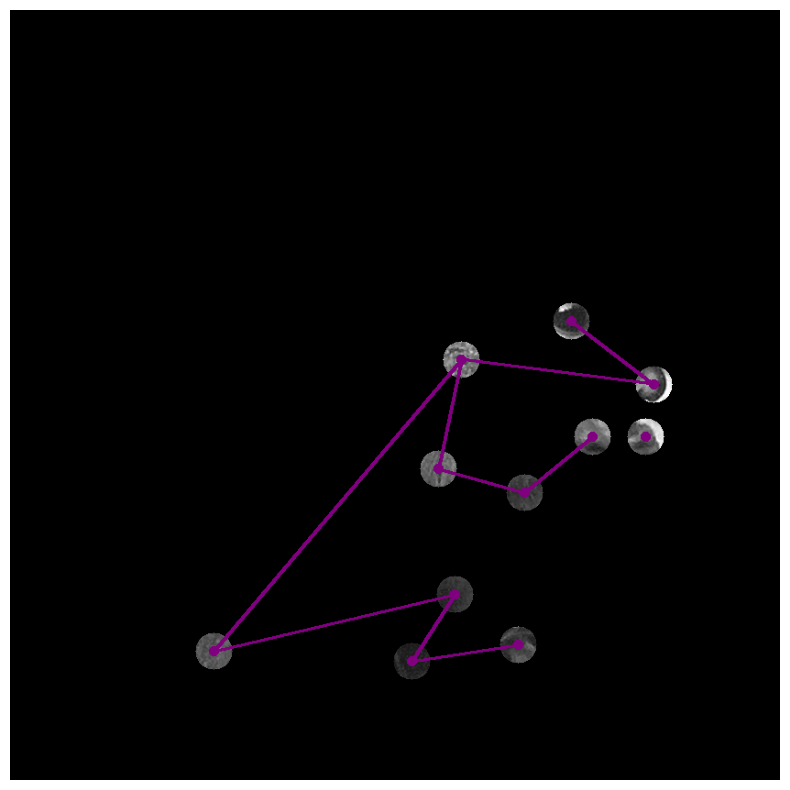

Have Generated Features for 600 Images.
First image for pig with size (840, 840)


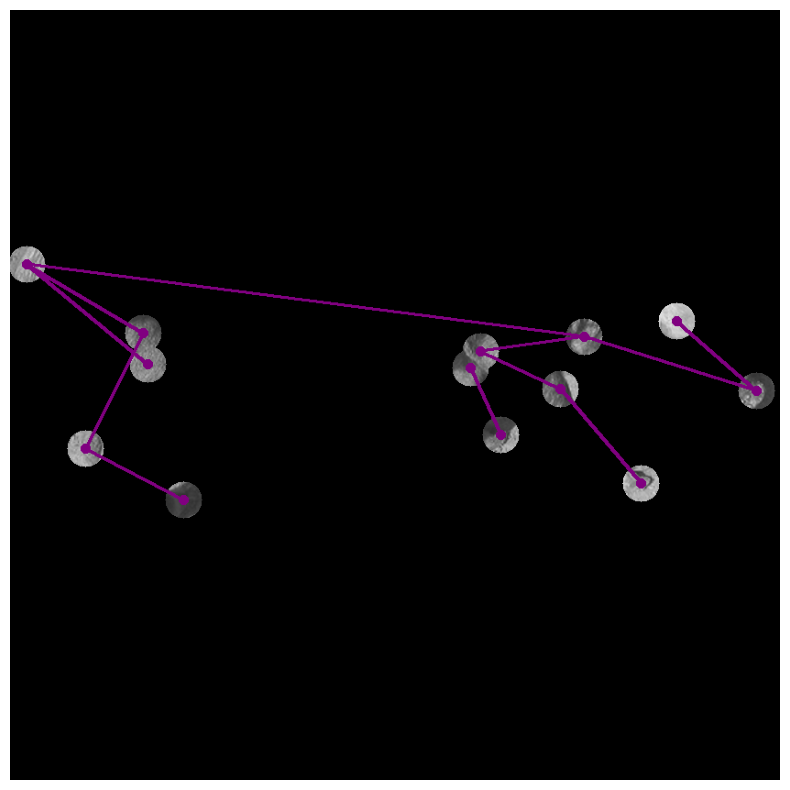

First image for brown bear with size (840, 840)


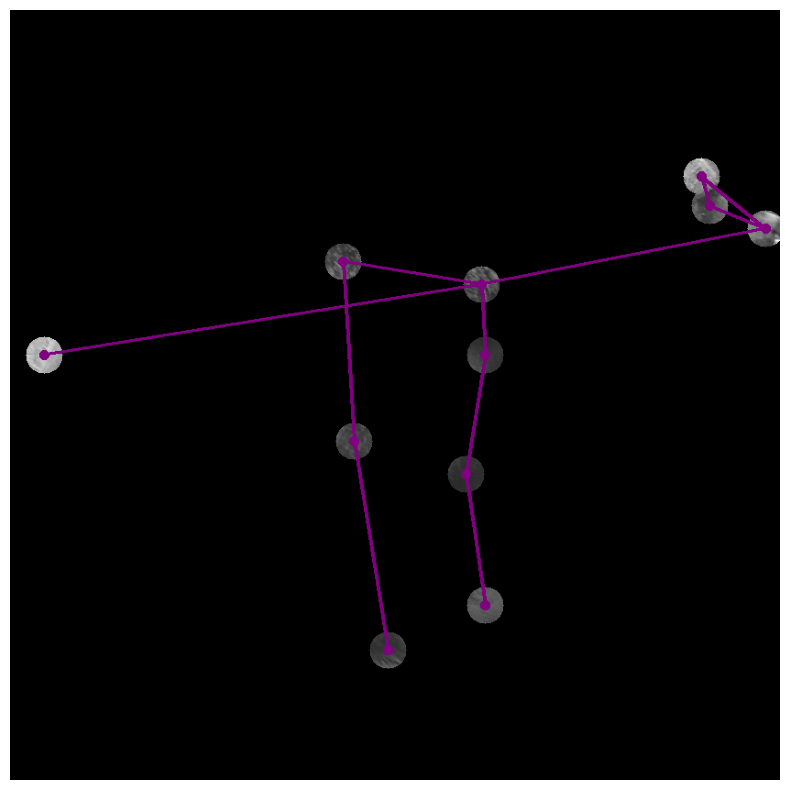

Have Generated Features for 700 Images.
First image for panda with size (840, 840)


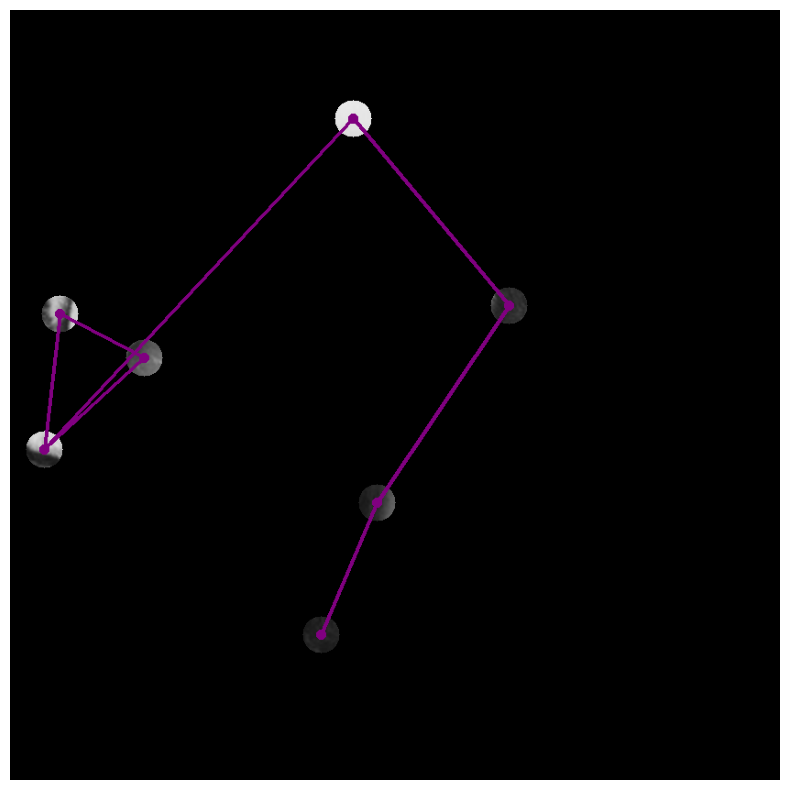

First image for polar bear with size (840, 840)


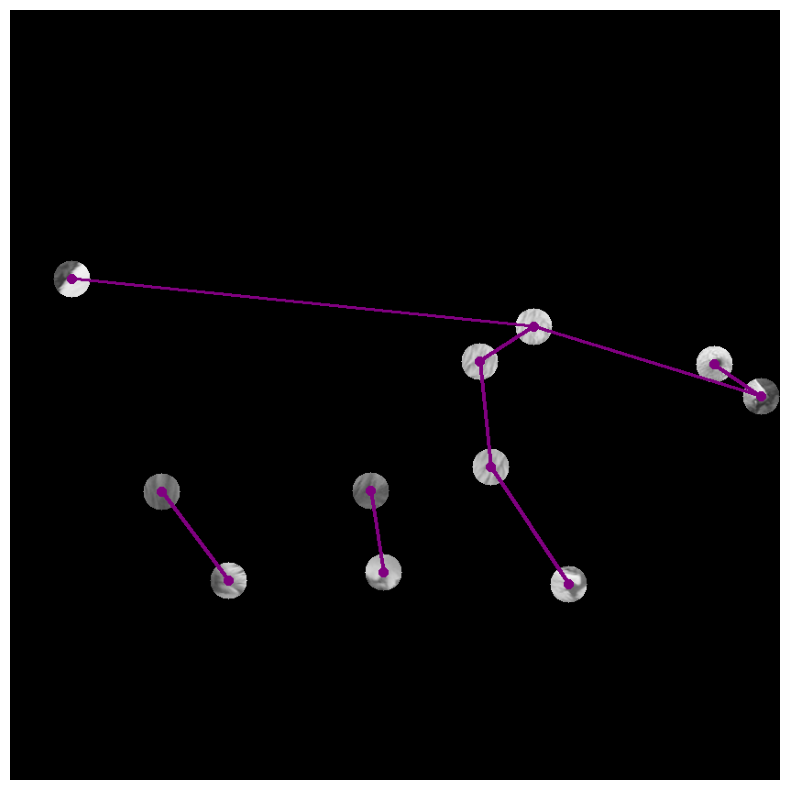

Have Generated Features for 800 Images.
First image for bison with size (840, 840)


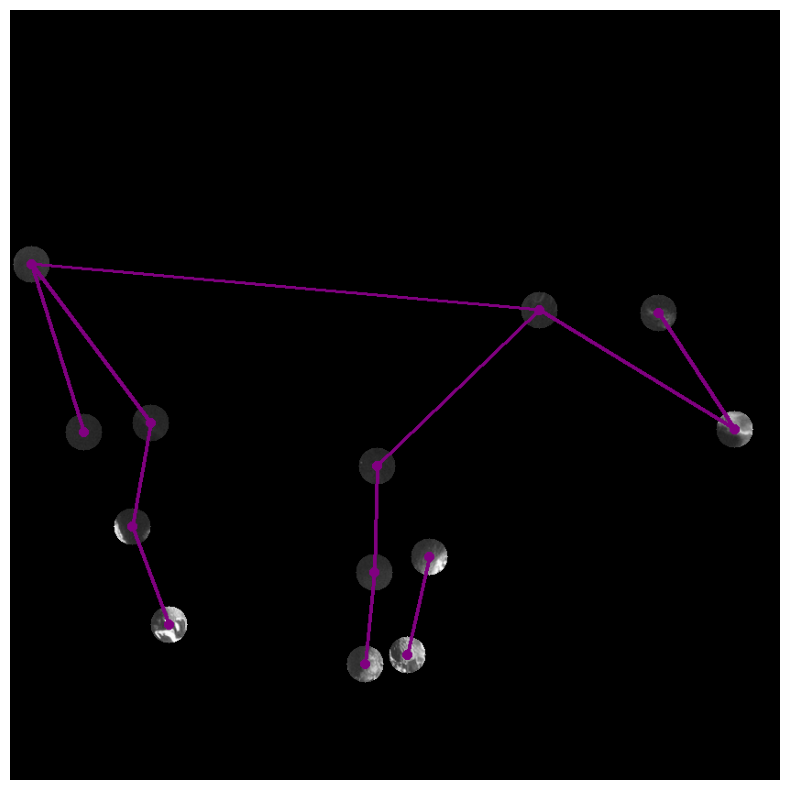

First image for buffalo with size (840, 840)


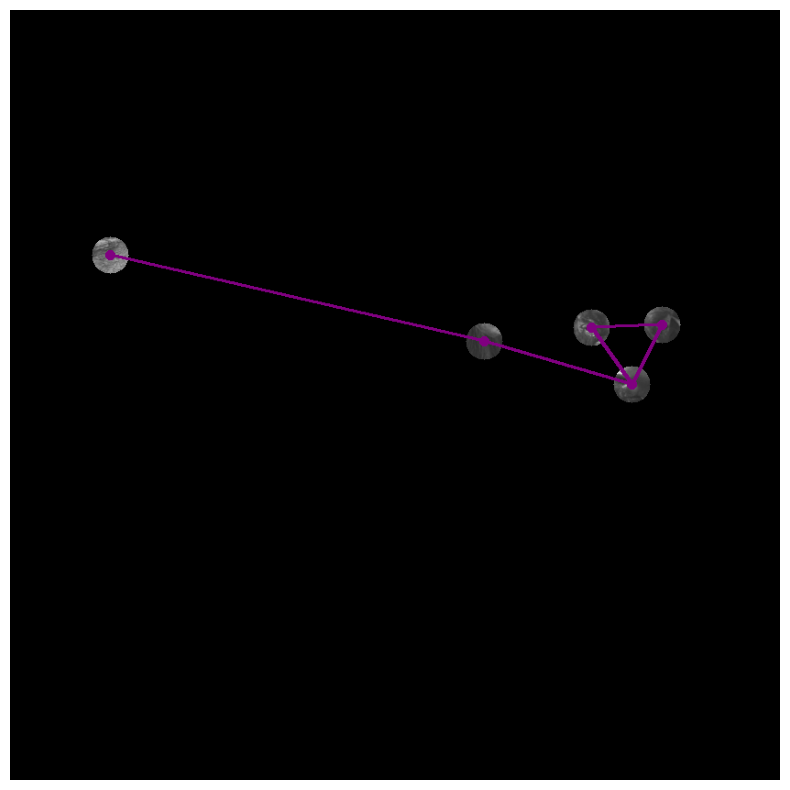

First image for fox with size (840, 840)


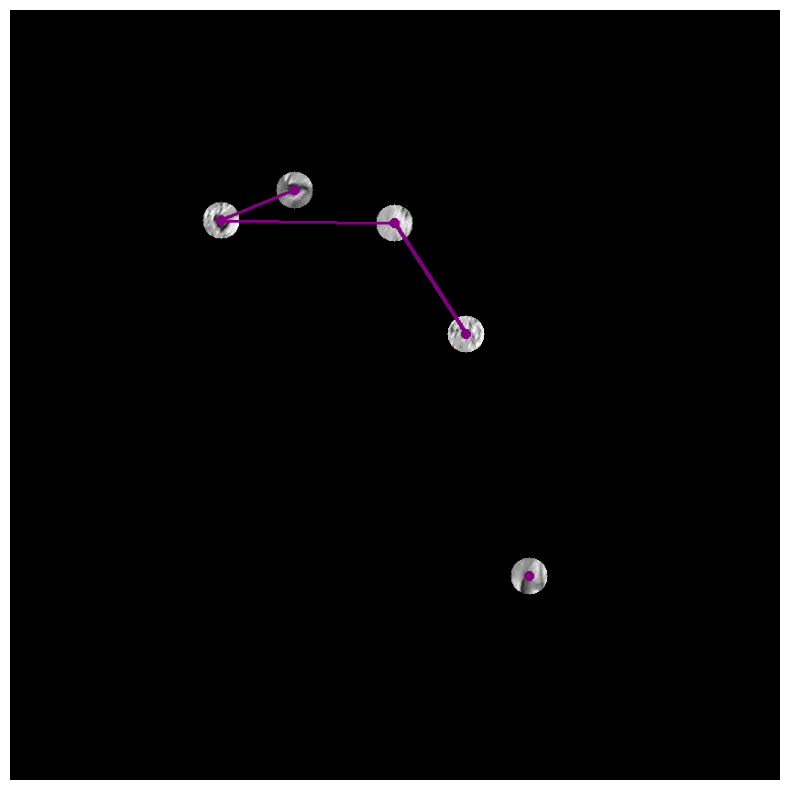

First image for moose with size (840, 840)


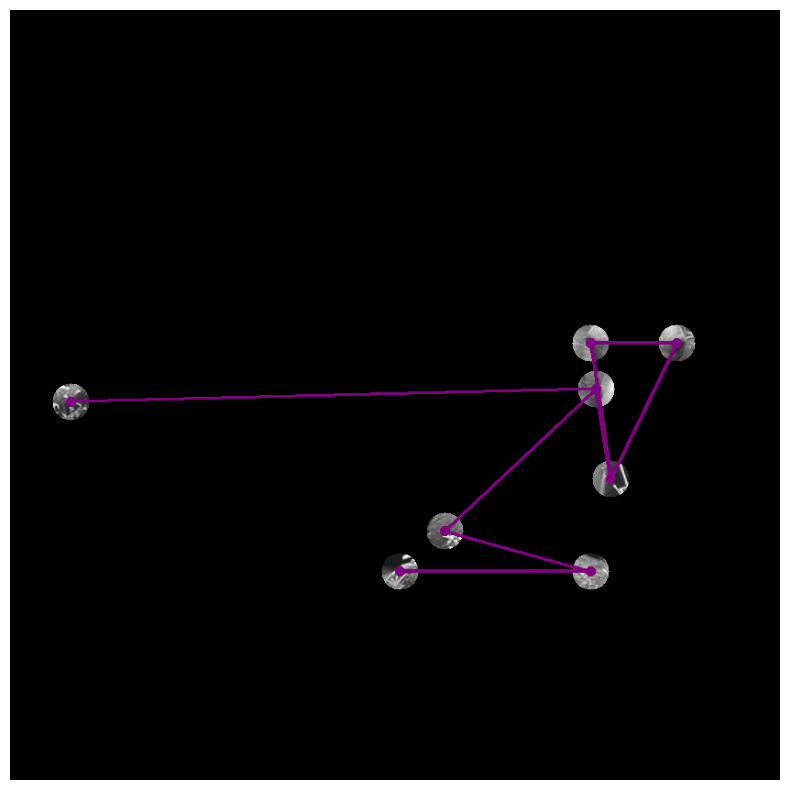

Have Generated Features for 900 Images.
First image for noisy night monkey with size (840, 840)


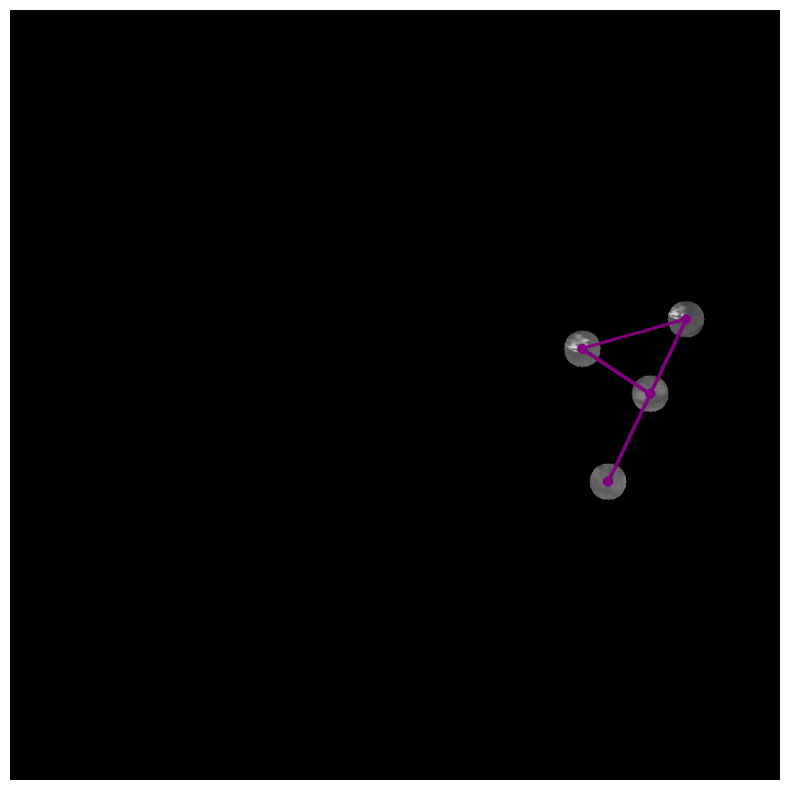

First image for alouatta with size (840, 840)


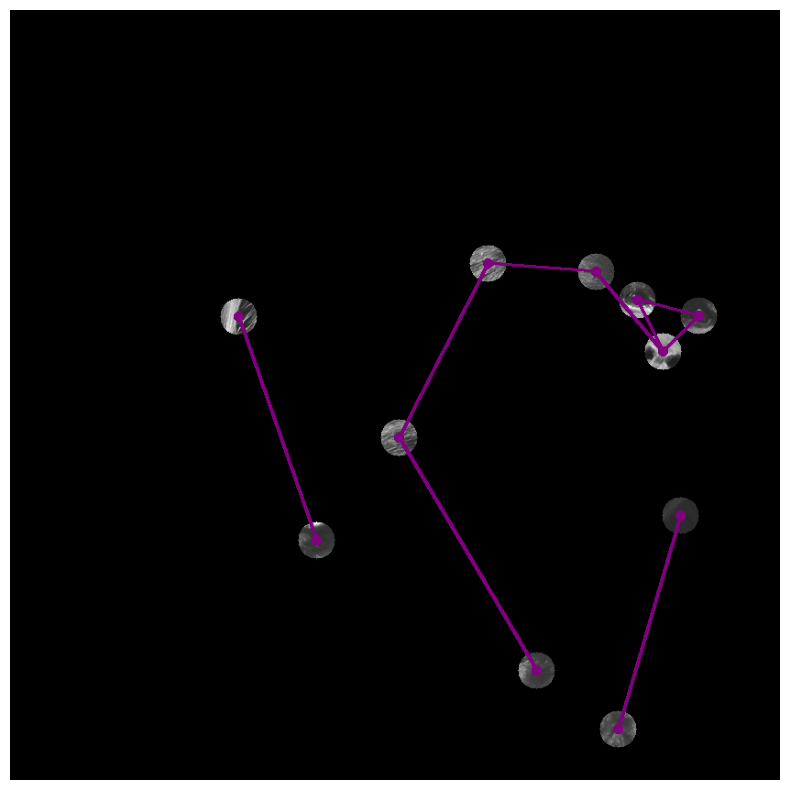

Have Generated Features for 1000 Images.
Have Generated Features for 1100 Images.
First image for antelope with size (840, 840)


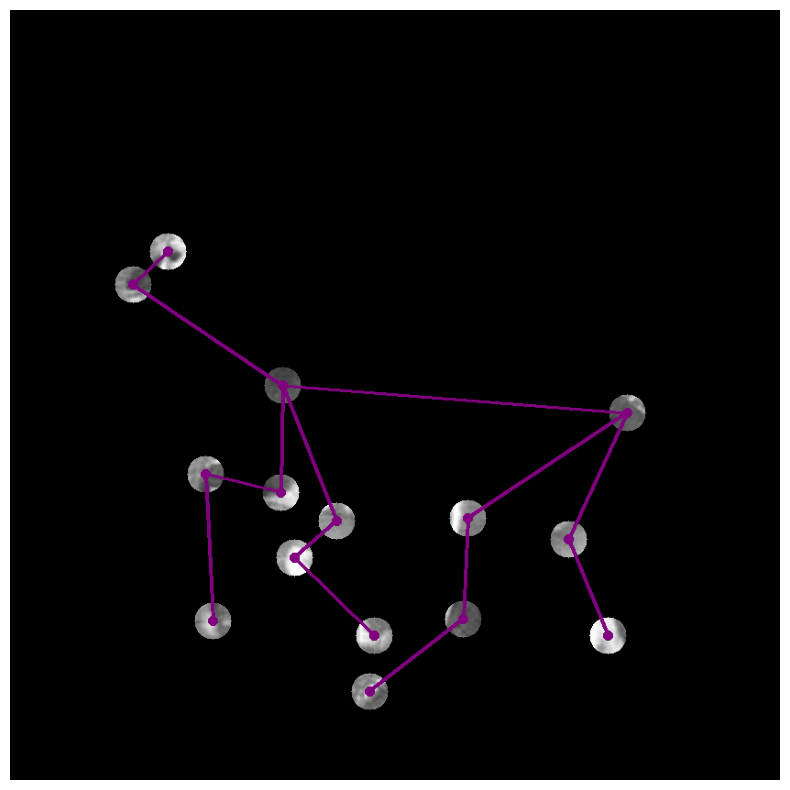

Have Generated Features for 1200 Images.
Have Generated Features for 1300 Images.
First image for cow with size (840, 840)


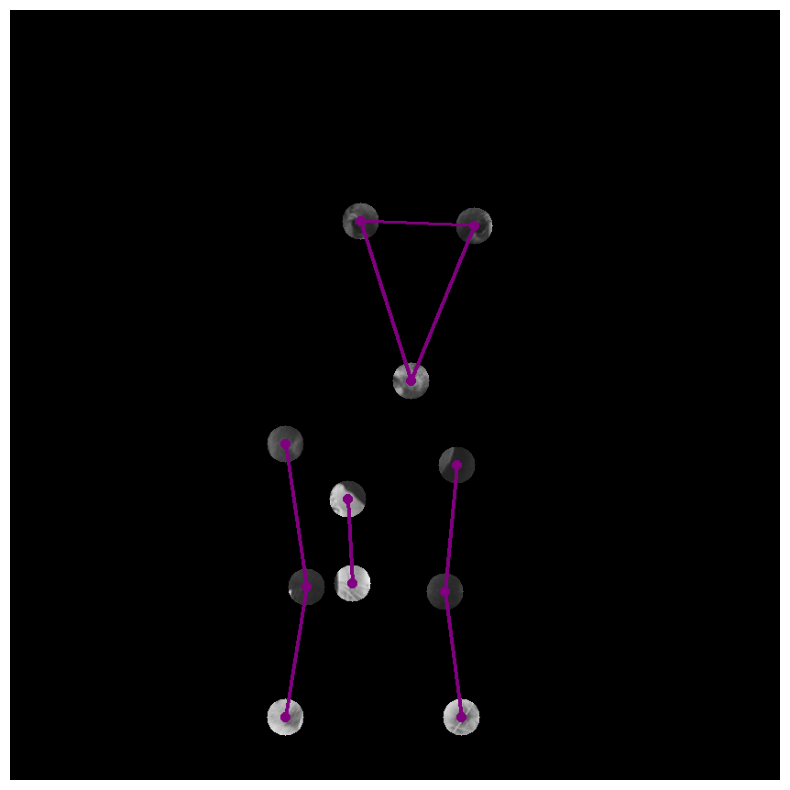

First image for sheep with size (840, 840)


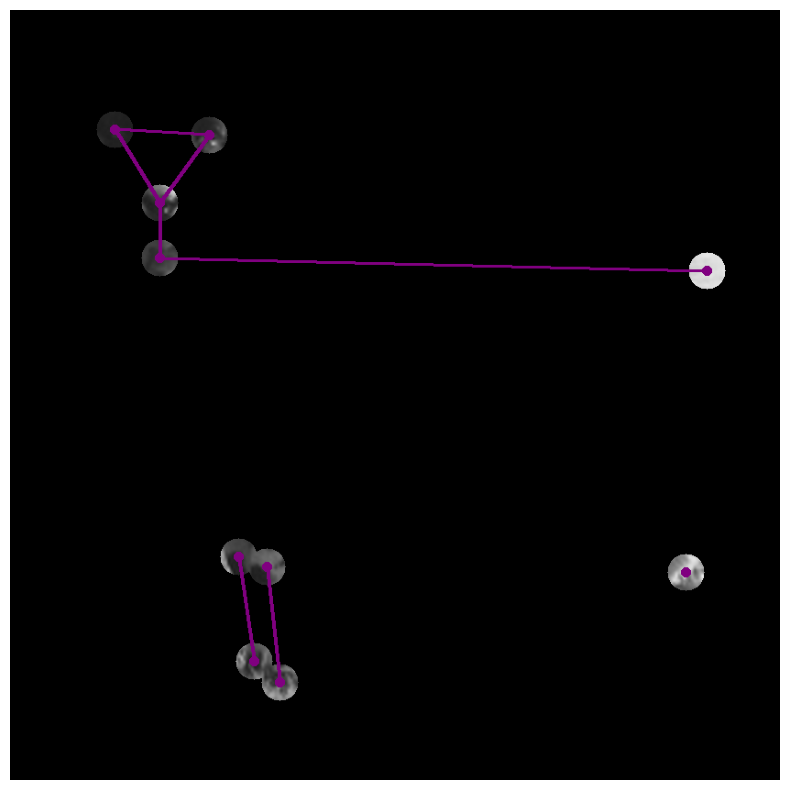

First image for dog with size (840, 840)


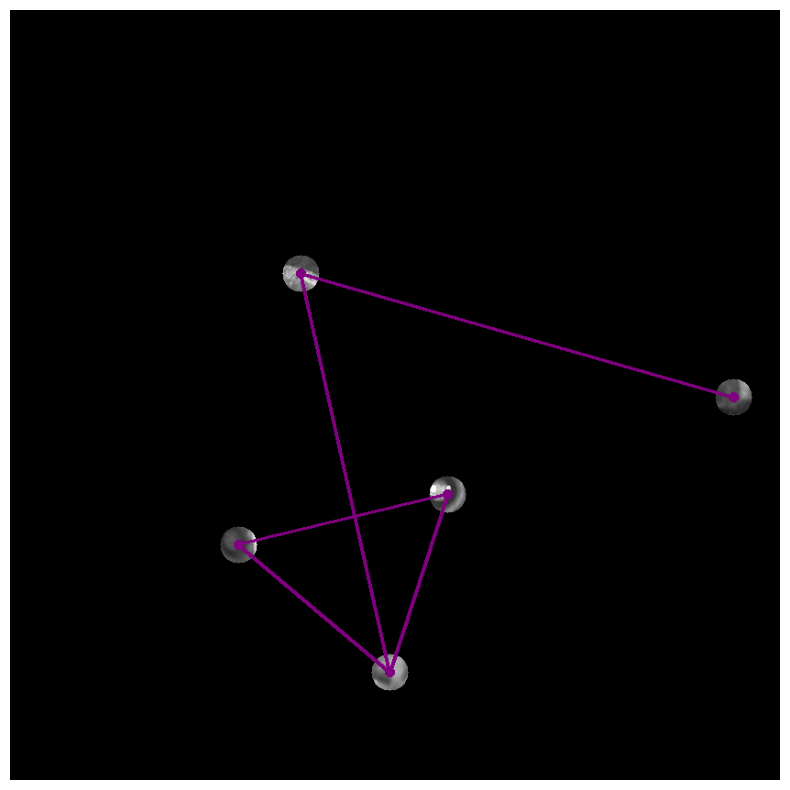

Have Generated Features for 1400 Images.
Have Generated Features for 1500 Images.
First image for wolf with size (840, 840)


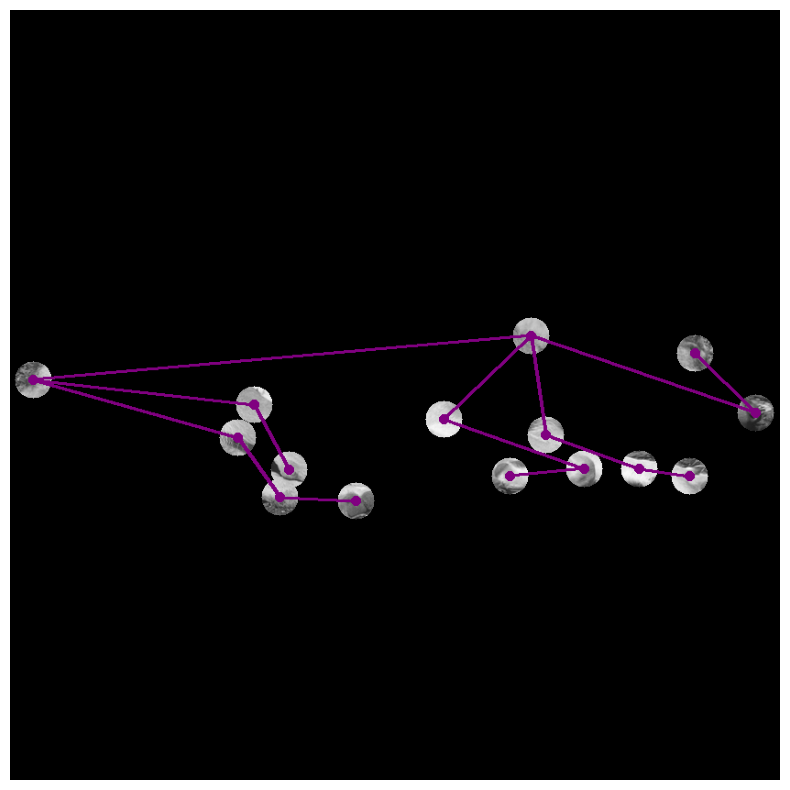

First image for beaver with size (840, 840)


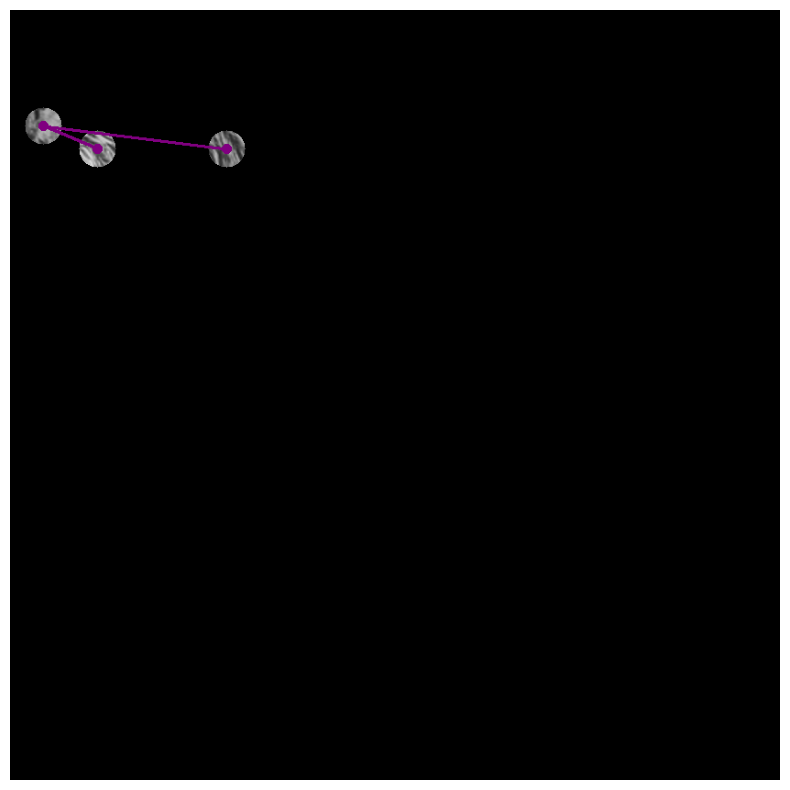

Have Generated Features for 1600 Images.
First image for spider monkey with size (840, 840)


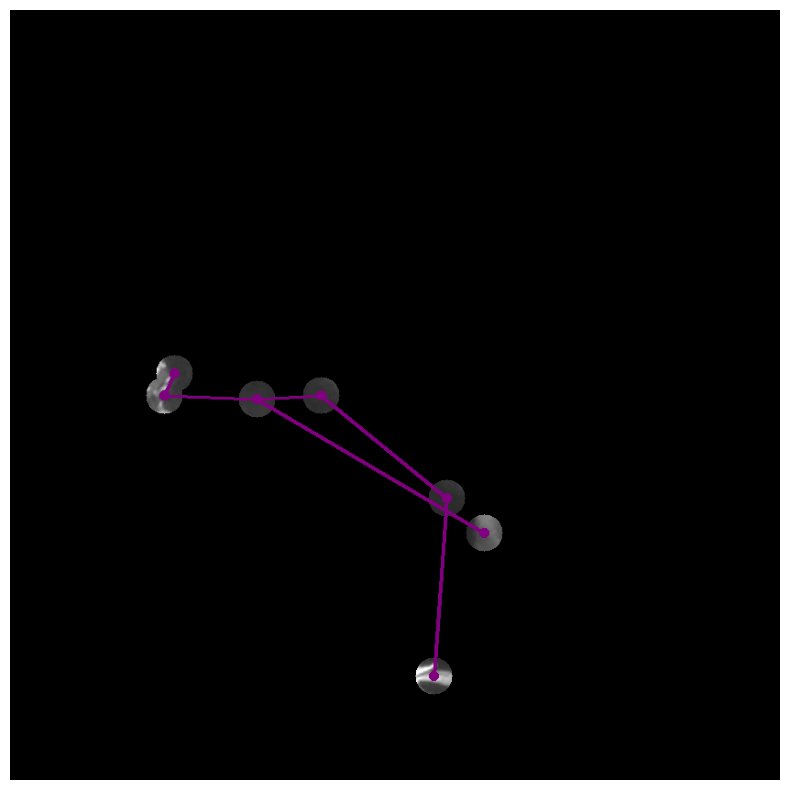

First image for deer with size (840, 840)


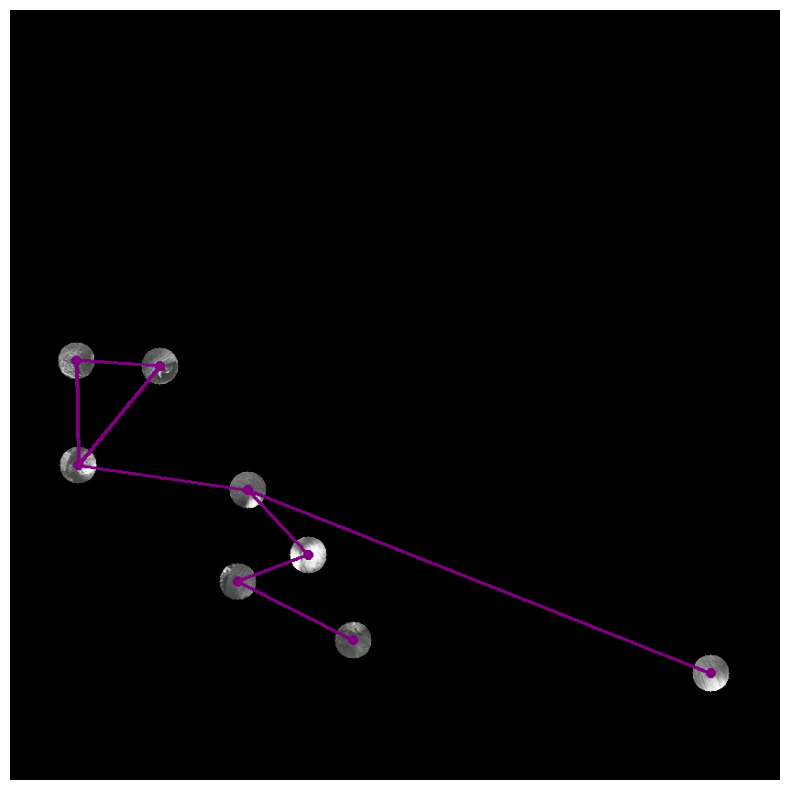

Have Generated Features for 1700 Images.
Have Generated Features for 1800 Images.
First image for elephant with size (840, 840)


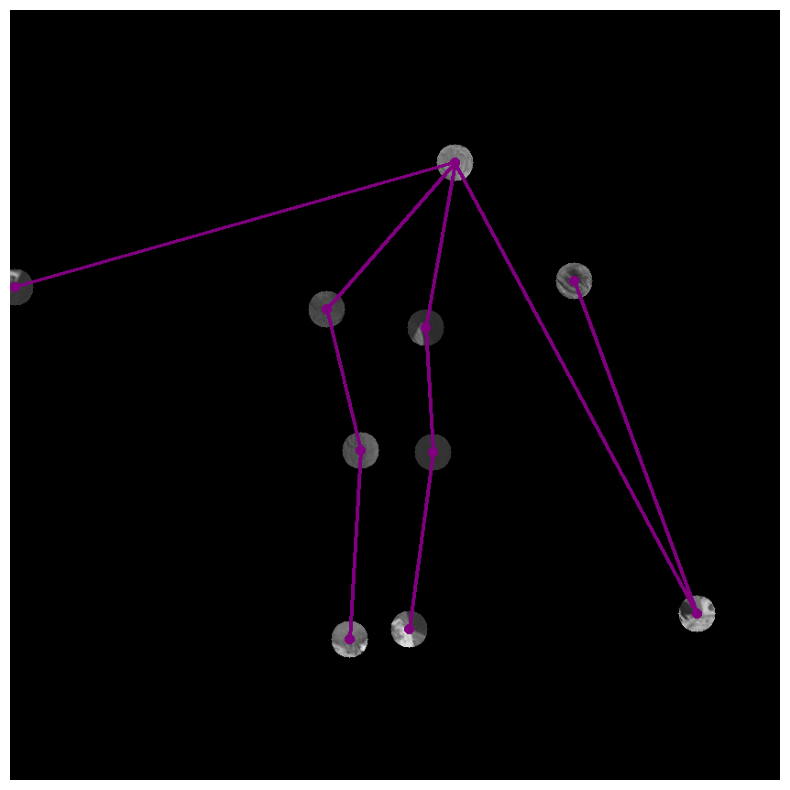

Have Generated Features for 1900 Images.
First image for horse with size (840, 840)


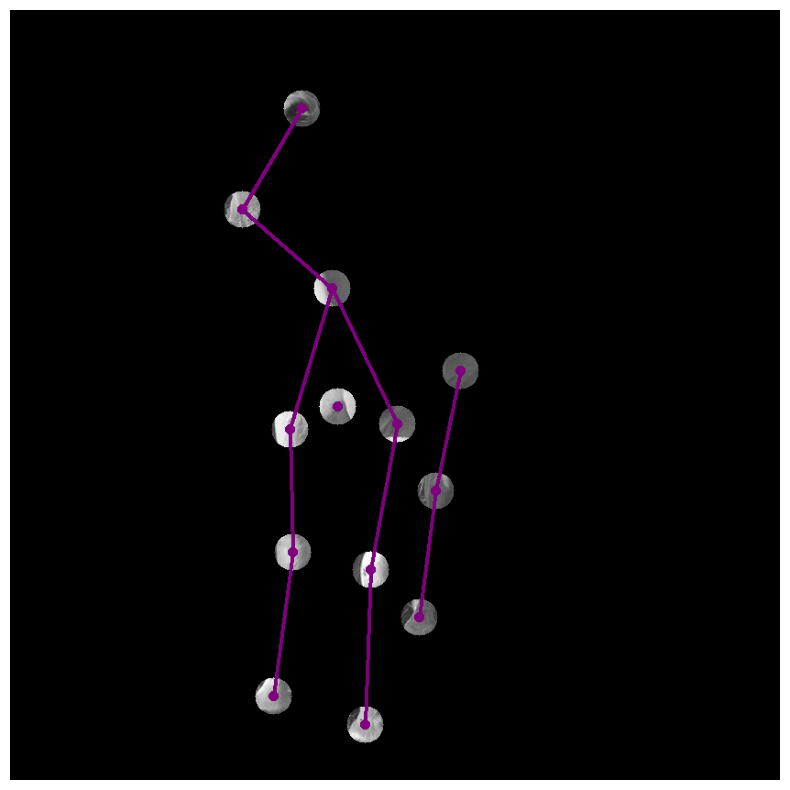

First image for zebra with size (840, 840)


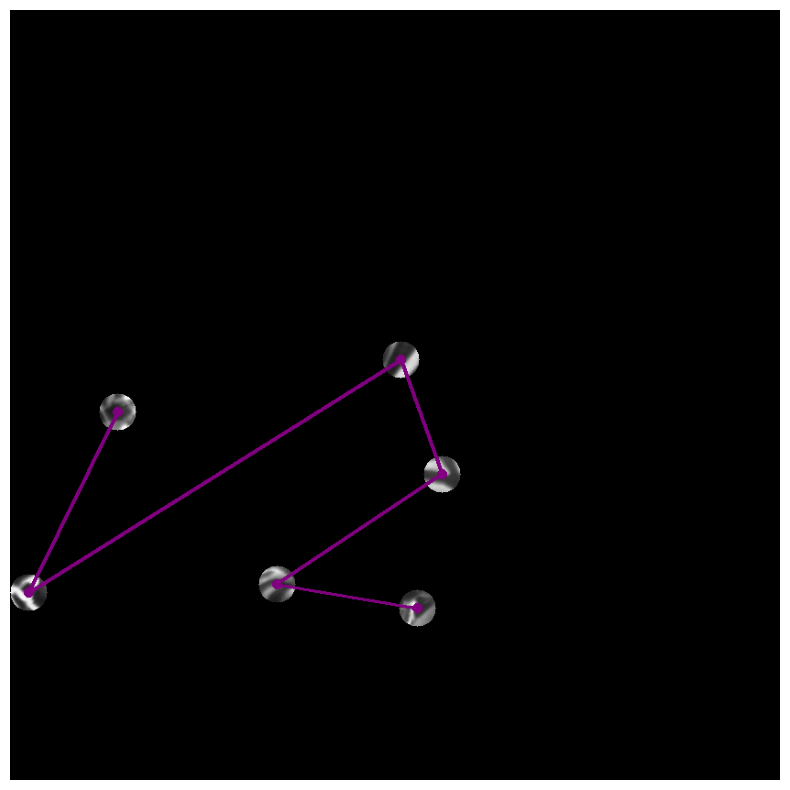

First image for bobcat with size (840, 840)


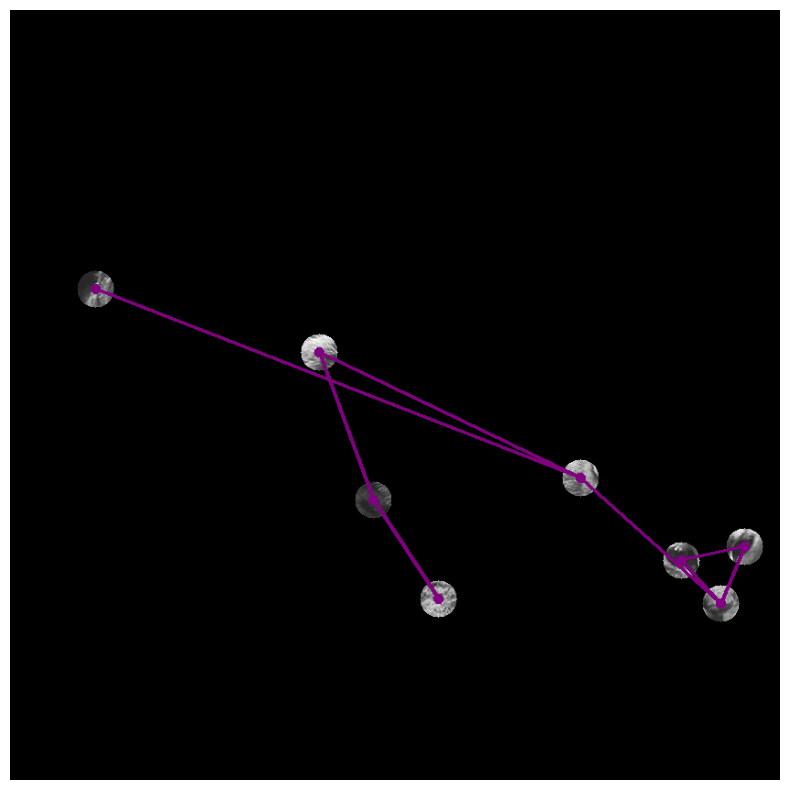

Have Generated Features for 2000 Images.
Have Generated Features for 2100 Images.
Have Generated Features for 2200 Images.
Have Generated Features for 2300 Images.
Have Generated Features for 2400 Images.
Have Generated Features for 2500 Images.
Have Generated Features for 2600 Images.
Have Generated Features for 2700 Images.
Have Generated Features for 2800 Images.
Have Generated Features for 2900 Images.
Have Generated Features for 3000 Images.
Have Generated Features for 3100 Images.
First image for lion with size (840, 840)


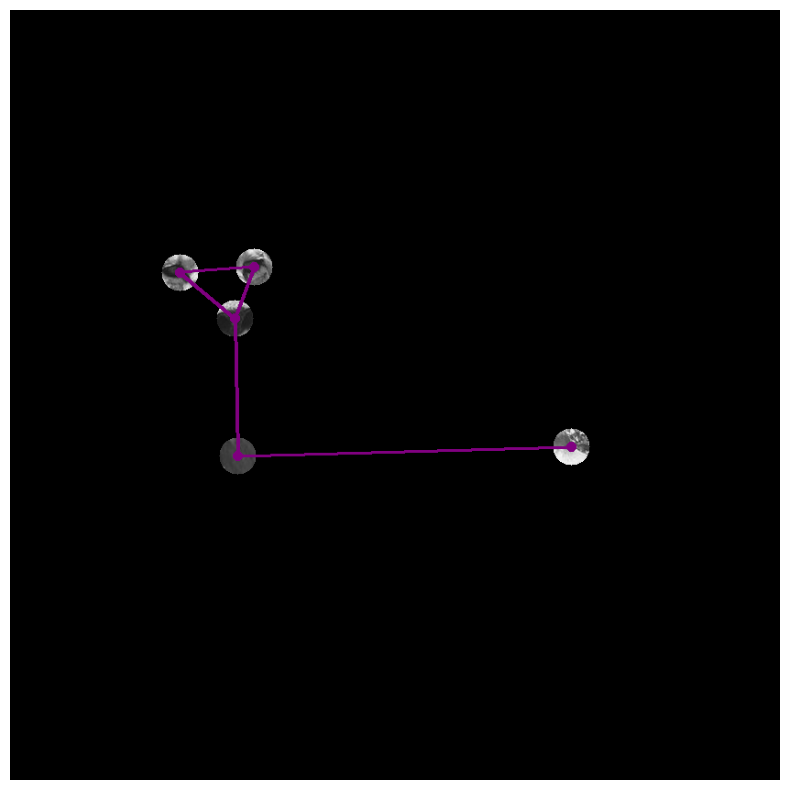

Have Generated Features for 3200 Images.
First image for panther with size (840, 840)


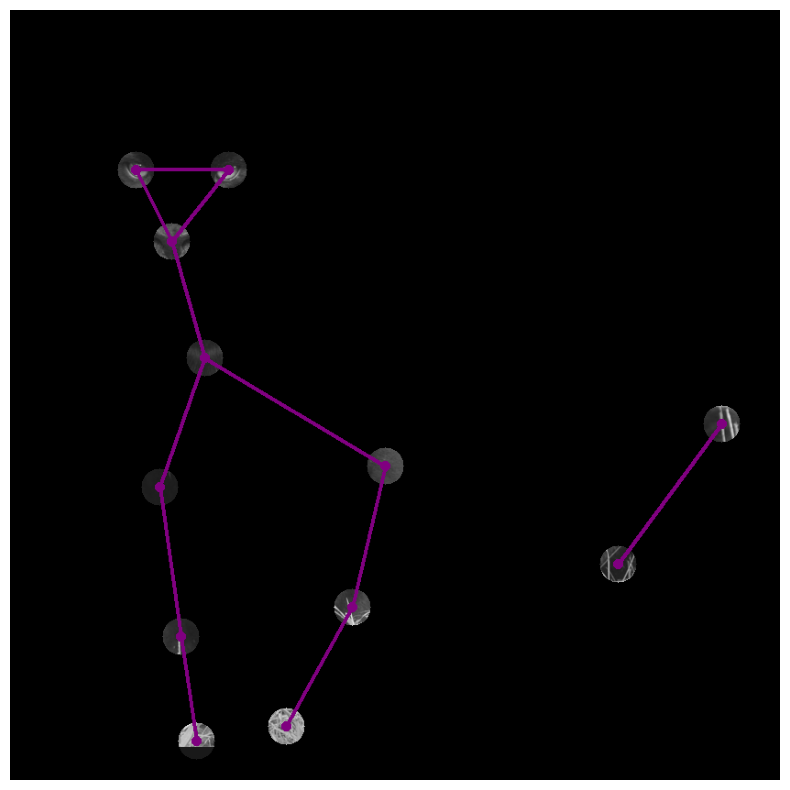

Have Generated Features for 3300 Images.
Have Generated Features for 3400 Images.
Have Generated Features for 3500 Images.
Have Generated Features for 3600 Images.
Have Generated Features for 3700 Images.
Have Generated Features for 3800 Images.
Have Generated Features for 3900 Images.
Have Generated Features for 4000 Images.
Have Generated Features for 4100 Images.
First image for monkey with size (840, 840)


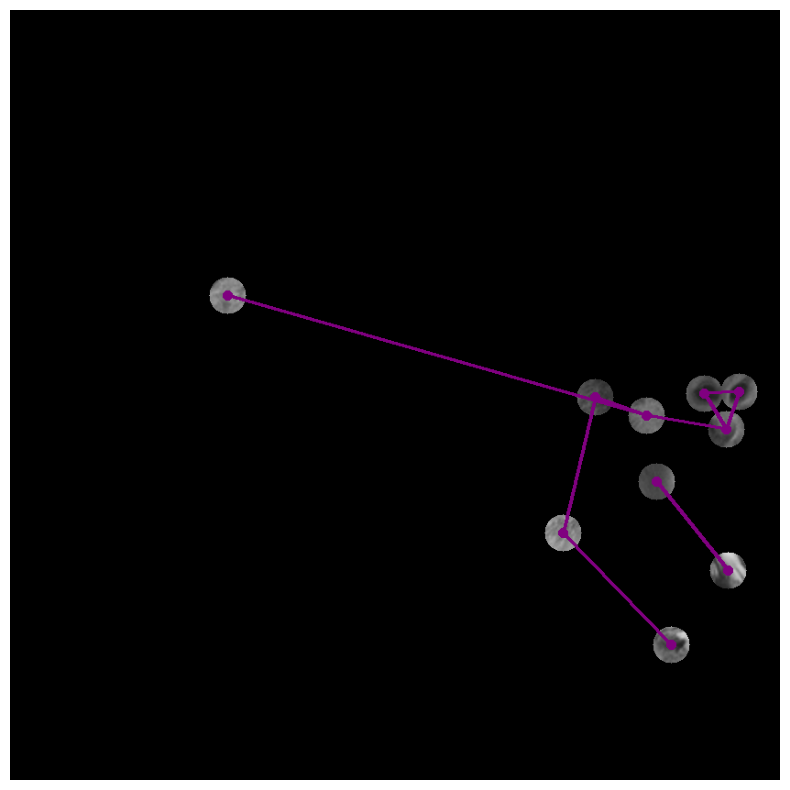

Have Generated Features for 4200 Images.
Have Generated Features for 4300 Images.
Have Generated Features for 4400 Images.
Have Generated Features for 4500 Images.
First image for hamster with size (840, 840)


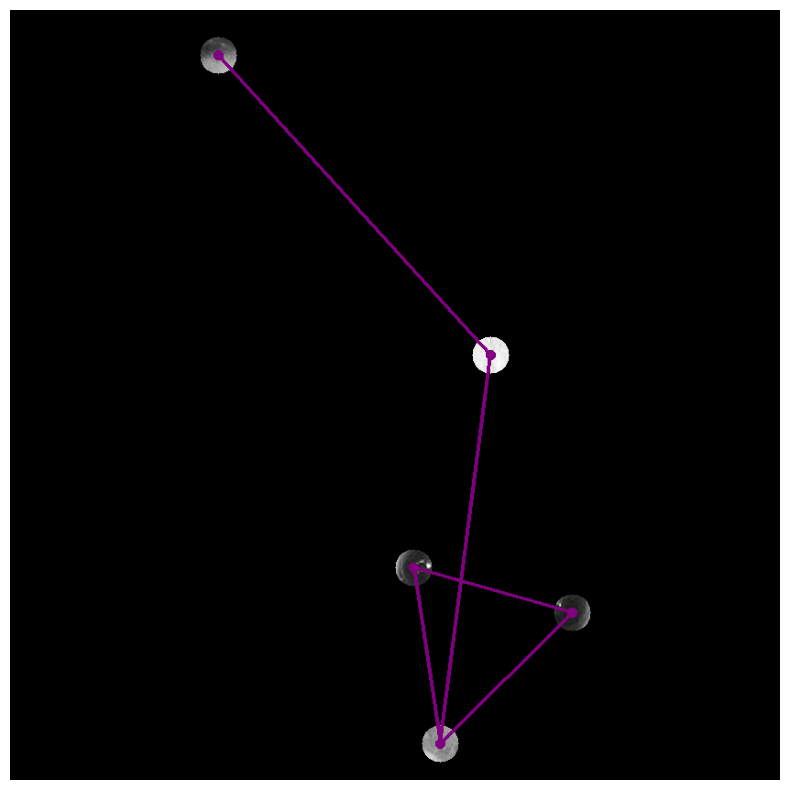

Have Generated Features for 4600 Images.
Have Generated Features for 4700 Images.
Have Generated Features for 4800 Images.
Have Generated Features for 4900 Images.
Have Generated Features for 5000 Images.
Have Generated Features for 5100 Images.
Have Generated Features for 5200 Images.
First image for argali sheep with size (840, 840)


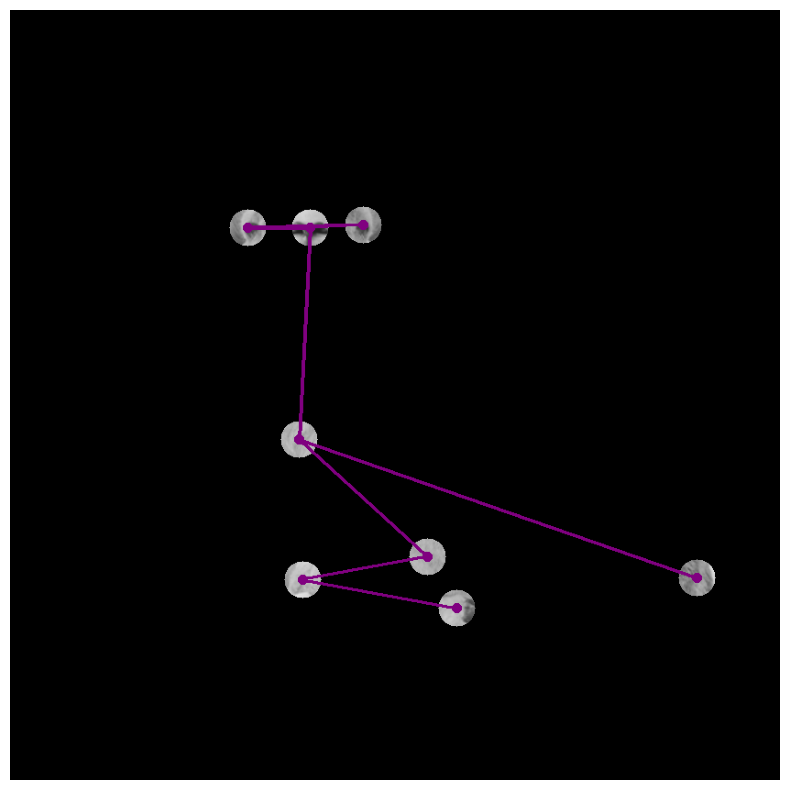

Have Generated Features for 5300 Images.
Have Generated Features for 5400 Images.
Have Generated Features for 5500 Images.
Have Generated Features for 5600 Images.
Have Generated Features for 5700 Images.
Have Generated Features for 5800 Images.
Have Generated Features for 5900 Images.
Have Generated Features for 6000 Images.
Have Generated Features for 6100 Images.
First image for gorilla with size (840, 840)


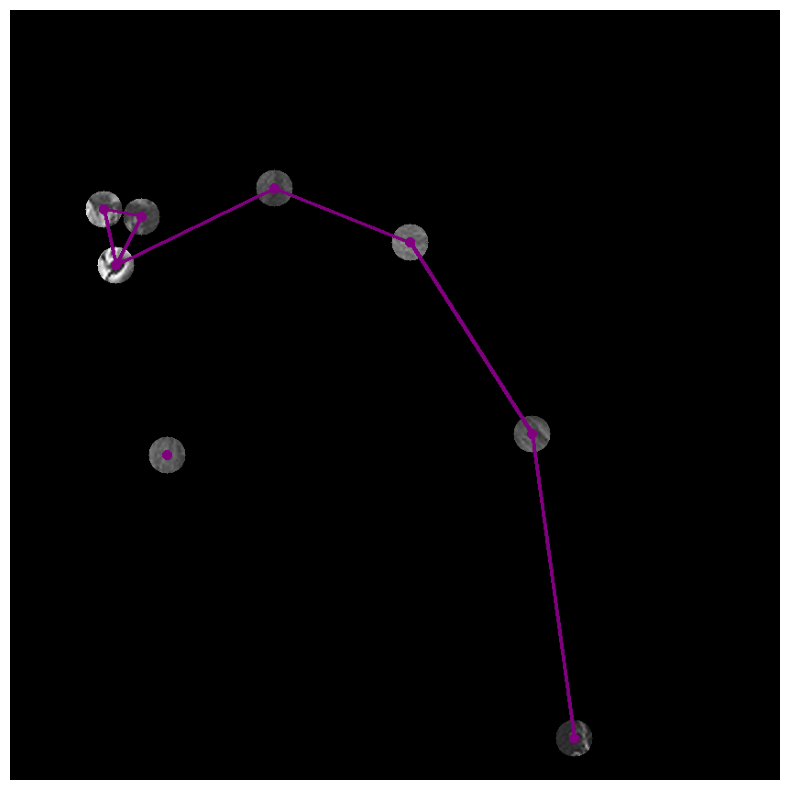

Have Generated Features for 6200 Images.
Have Generated Features for 6300 Images.
Have Generated Features for 6400 Images.
Have Generated Features for 6500 Images.
Have Generated Features for 6600 Images.
Have Generated Features for 6700 Images.
First image for marmot with size (840, 840)


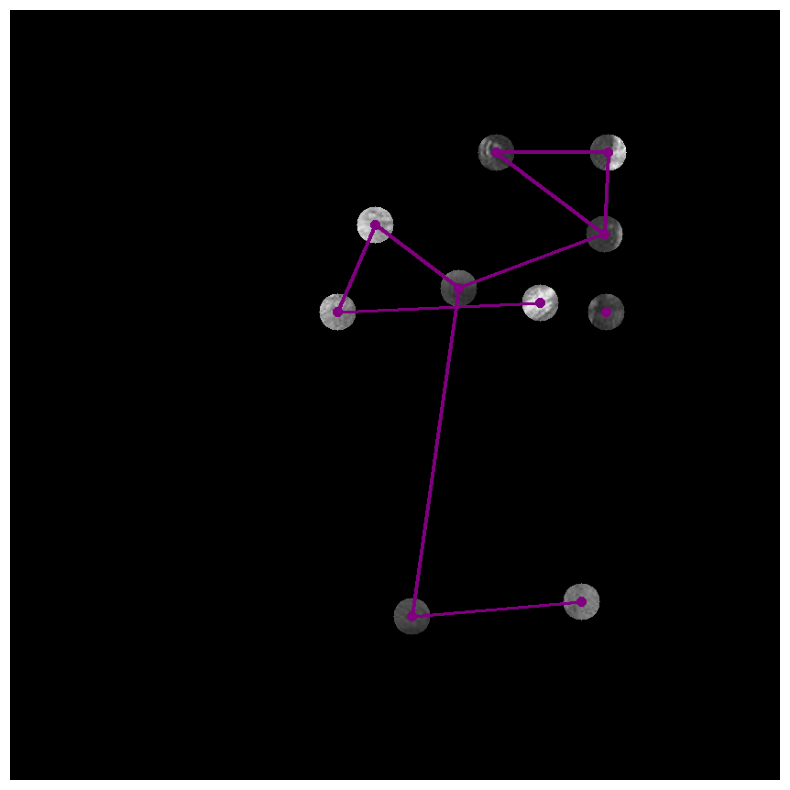

Have Generated Features for 6800 Images.
Have Generated Features for 6900 Images.
First image for black bear with size (840, 840)


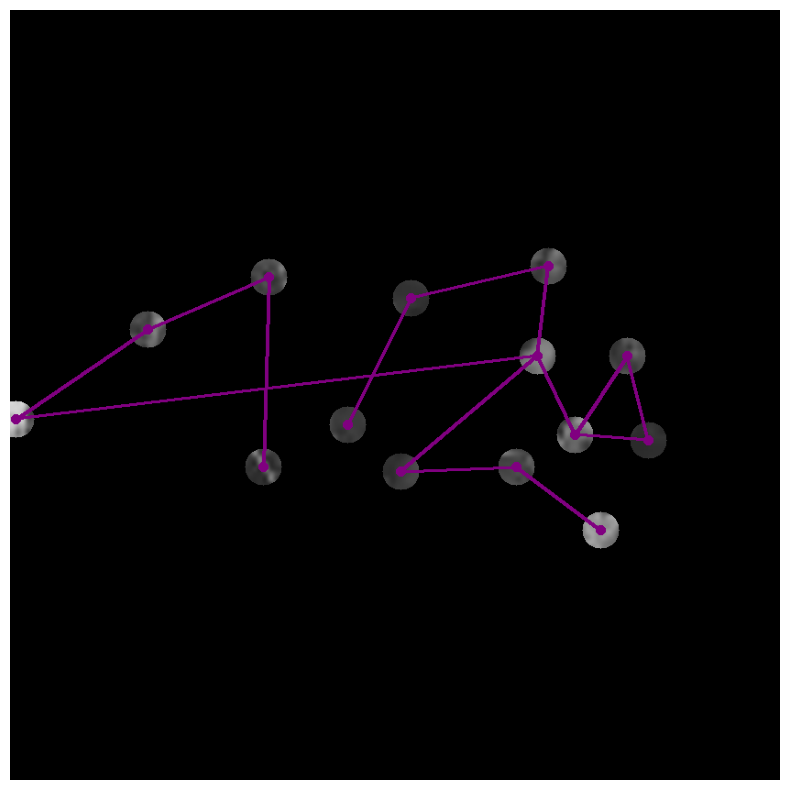

Have Generated Features for 7000 Images.
First image for cheetah with size (840, 840)


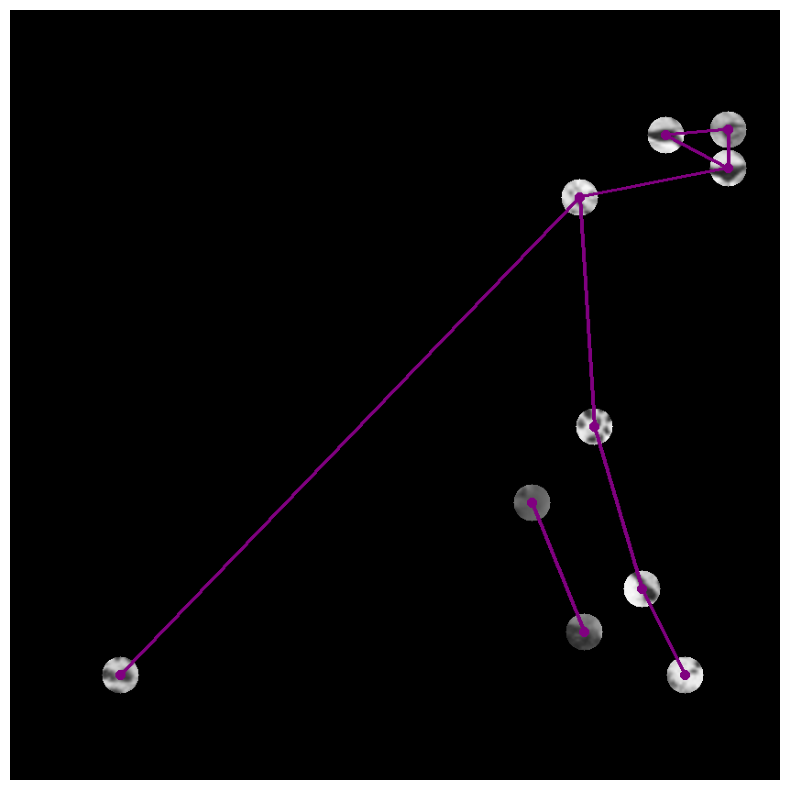

Have Generated Features for 7100 Images.
Have Generated Features for 7200 Images.
Have Generated Features for 7300 Images.
Have Generated Features for 7400 Images.
First image for king cheetah with size (840, 840)


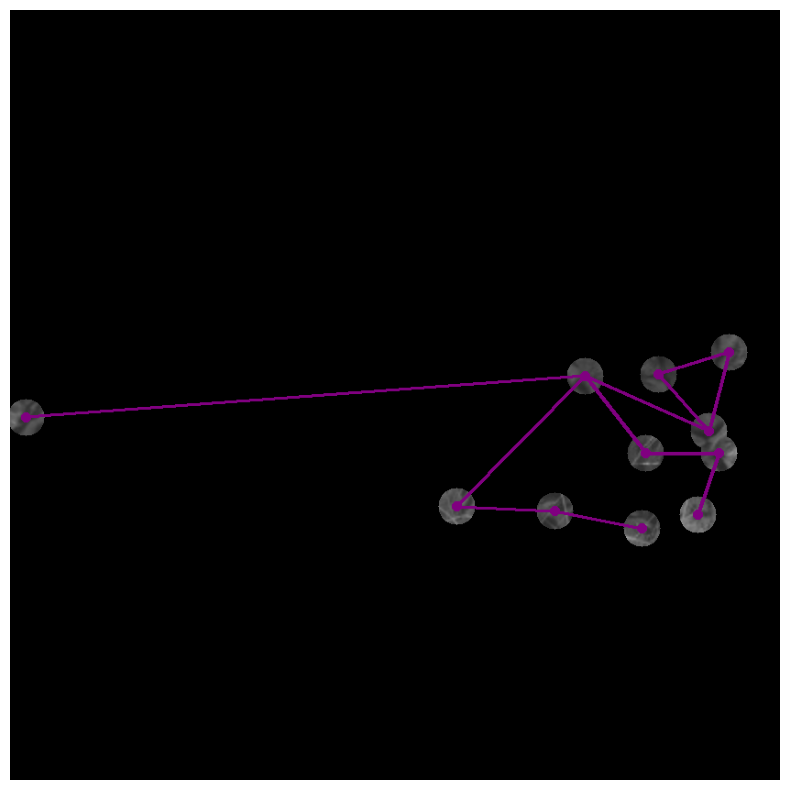

Have Generated Features for 7500 Images.
Have Generated Features for 7600 Images.
Have Generated Features for 7700 Images.
Have Generated Features for 7800 Images.
First image for snow leopard with size (840, 840)


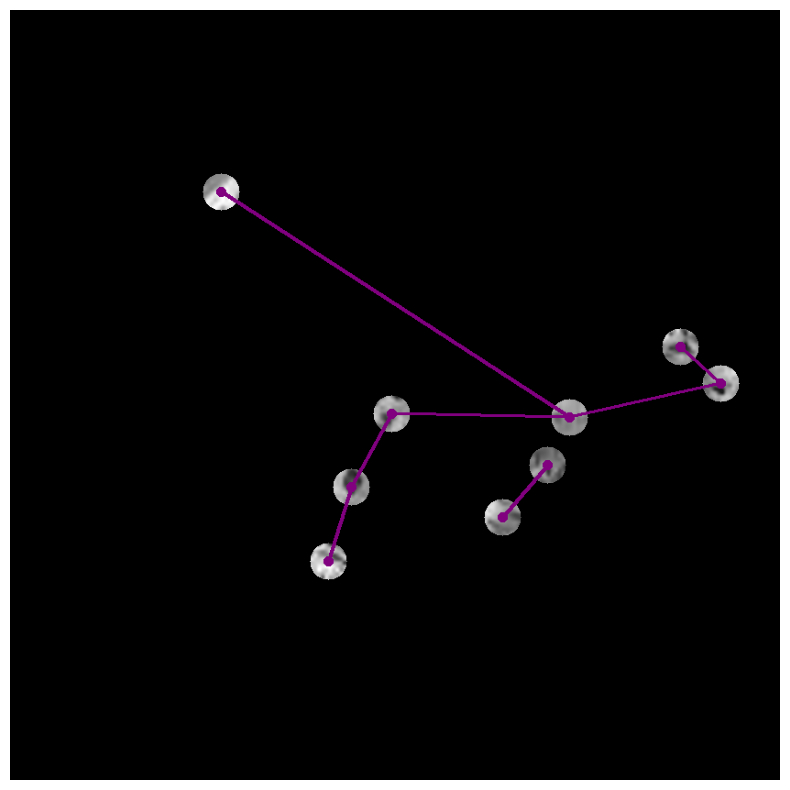

Have Generated Features for 7900 Images.
Have Generated Features for 8000 Images.
Have Generated Features for 8100 Images.
Have Generated Features for 8200 Images.
Have Generated Features for 8300 Images.
Have Generated Features for 8400 Images.
Have Generated Features for 8500 Images.
Have Generated Features for 8600 Images.
Have Generated Features for 8700 Images.
Have Generated Features for 8800 Images.
Have Generated Features for 8900 Images.
Have Generated Features for 9000 Images.
Have Generated Features for 9100 Images.
Have Generated Features for 9200 Images.
Have Generated Features for 9300 Images.
Have Generated Features for 9400 Images.
Have Generated Features for 9500 Images.
Have Generated Features for 9600 Images.
Have Generated Features for 9700 Images.
Have Generated Features for 9800 Images.
Have Generated Features for 9900 Images.
Have Generated Features for 10000 Images.
Feature extraction completed!


In [23]:
import os
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

dinov2_vitl14.to(device)

# Define paths
ap10k_folder = "/content/drive/MyDrive/ap10k/"
data_folder = os.path.join(ap10k_folder, "data")
annotations_path = os.path.join(ap10k_folder, "annotations", "annotations.json")

# Load AP10K annotations
with open(annotations_path, 'r') as file:
    annotations_data = json.load(file)

# Organize annotations by image_id
image_annotations = {ann["image_id"]: ann for ann in annotations_data["annotations"]}

# Assuming 'categories' is a list where each element is a dictionary containing 'id' and 'name'
categories = annotations_data['categories']  # Replace with your actual categories list or dictionary

# Create a mapping from category_id to category_name
category_mapping = {category['id']: category['name'] for category in categories}
print(category_mapping)

# Dictionary to store features by species
species_features = {}

# DINOv2 settings
patch_size = dinov2_vitl14.patch_size  # 14 for ViT-L/14
patch_h, patch_w = 224 // patch_size, 224 // patch_size
feat_dim = 1024  # ViT-L/14
cnt = 0
img_size = 840  # img size for resizing as DINOv2 + SD paper resizes to 840x840

# Iterate through images in the data folder
with torch.no_grad():
    for file in os.listdir(data_folder):
        cnt += 1
        if cnt % 100 == 0:
            print(f"Have Generated Features for {cnt} Images.")
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            file_path = os.path.join(data_folder, file)
            image_id = int(os.path.splitext(file)[0])

            # Get species and bbox info from annotations
            annotation = image_annotations.get(image_id)
            if not annotation:
                continue  # Skip if no annotation
                print("Could Not Find Annotation!!")
            species_name = category_mapping[annotation["category_id"]]
            gt_bbox = annotation["bbox"]

            # Extract keypoints if available
            num_keypoints = annotation.get('num_keypoints', 0)
            original_keypoints = annotation.get('keypoints', [])

            # Open image
            image = Image.open(file_path).convert("RGB")
            image_np = np.array(image)
            img_h, img_w = image_np.shape[:2]

            # # If keypoints exist, draw them on the image
            # if num_keypoints > 0 and original_keypoints:
            #     # Parse flattened keypoints list
            #     parsed_keypoints = parse_flattened_keypoints(original_keypoints, num_keypoints)

            #     # print(f"Number of keypoints: {num_keypoints}")
            #     # print(f"Parsed Keypoints: {parsed_keypoints}")

            #     # Draw keypoints on the image
            #     #image_with_keypoints = draw_keypoints(image, parsed_keypoints)
            #     image_with_keypoints = draw_skeleton(image, parsed_keypoints)

            #     # # Optional: Display the image with keypoints for verification
            #     # plt.figure(figsize=(10, 10))
            #     # plt.imshow(image_with_keypoints)
            #     # plt.title(f"Keypoints for {species_name}")
            #     # plt.axis('off')
            #     # plt.show()

            #     # Use image_with_keypoints for further processing
            #     image = image_with_keypoints

            image_np = np.array(image)
            img_h, img_w = image_np.shape[:2]

            # Extract bounding box
            x_min, y_min, width, height = gt_bbox
            x_max, y_max = x_min + width, y_min + height
            bbox = [x_min, y_min, x_max, y_max]

            # # Create keypoint mask
            # keypoint_mask = create_keypoint_mask(image_np.shape, original_keypoints, num_keypoints)

            # # Convert image to grayscale
            # grayscale_image = np.dot(image_np[...,:3], [0.2989, 0.5870, 0.1140])
            # grayscale_image = grayscale_image / 255.0 * 0.9 + 0.1


            # # Apply mask to grayscale image
            # grayscale_image[~keypoint_mask] = 0
            # grayscale_image = (grayscale_image * 255).astype(np.uint8)

            # # Create masked image
            # image_with_mask = image_np.copy()
            # image_with_mask[~keypoint_mask] = 0
            # image_with_mask[keypoint_mask] = np.expand_dims(grayscale_image, axis=-1)[keypoint_mask]

            # --- 1. Cropping ---
            x_min, y_min, width, height = map(int, gt_bbox)
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(img_w, x_min + width)
            y_max = min(img_h, y_min + height)
            crop_width = x_max - x_min
            crop_height = y_max - y_min

            if crop_width <= 0 or crop_height <= 0: continue

            cropped_image_np = image_np[y_min:y_max, x_min:x_max]
            cropped_image = Image.fromarray(cropped_image_np)
            original_cropped_width, original_cropped_height = cropped_image.size # Size AFTER crop

            # --- Store parameters needed for the mask function ---
            crop_origin = (x_min, y_min)
            original_crop_size = (original_cropped_width, original_cropped_height)
            # ----------------------------------------------------

            # --- 2. Resizing ---
            aspect_ratio = original_cropped_width / original_cropped_height
            if original_cropped_width >= original_cropped_height:
                new_width = img_size
                new_height = int(img_size / aspect_ratio)
            else:
                new_height = img_size
                new_width = int(img_size * aspect_ratio)
            new_width = max(1, new_width)
            new_height = max(1, new_height)

            resized_image = cropped_image.resize((new_width, new_height), Image.BICUBIC)
            resized_width, resized_height = resized_image.size

            # --- Store parameters needed for the mask function ---
            scale_x = resized_width / original_cropped_width if original_cropped_width > 0 else 1
            scale_y = resized_height / original_cropped_height if original_cropped_height > 0 else 1
            resize_scale = (scale_x, scale_y)
            # ----------------------------------------------------

            # --- 3. Padding ---
            left_pad = (img_size - resized_width) // 2
            top_pad = (img_size - resized_height) // 2
            right_pad = img_size - resized_width - left_pad
            bottom_pad = img_size - resized_height - top_pad

            padded_image = ImageOps.expand(resized_image, (left_pad, top_pad, right_pad, bottom_pad), fill='black')
            final_image_pil = padded_image
            final_image_np = np.array(final_image_pil) # Final 840x840 numpy array

            # --- Store parameters needed for the mask function ---
            padding_offset = (left_pad, top_pad)
            # ----------------------------------------------------

            # --- Create Mask ---
            # Pass the original keypoints and all transformation parameters
            keypoint_mask = create_keypoint_mask_transform_inside(
                final_image_shape=final_image_np.shape,
                original_keypoints=original_keypoints, # Pass original keypoints
                num_keypoints=num_keypoints,
                crop_origin=crop_origin,
                original_crop_size=original_crop_size,
                resize_scale=resize_scale,
                padding_offset=padding_offset
            )
            # ------------------------------------------

            # Convert image to grayscale
            grayscale_image = np.dot(final_image_np[...,:3], [0.2989, 0.5870, 0.1140])
            grayscale_image = grayscale_image / 255.0 * 0.9 + 0.1

            # Apply mask to grayscale image
            grayscale_image[~keypoint_mask] = 0
            grayscale_image = (grayscale_image * 255).astype(np.uint8)

            # Create masked image
            image_with_mask = final_image_np.copy()
            image_with_mask[~keypoint_mask] = 0
            image_with_mask[keypoint_mask] = np.expand_dims(grayscale_image, axis=-1)[keypoint_mask]

            # Drawing keypoints with color -> Comment out if want keypoints to be grayscaled as well
            if num_keypoints > 0 and original_keypoints:
                image_with_mask = Image.fromarray(image_with_mask)

                # Parse flattened keypoints list
                parsed_keypoints = parse_flattened_keypoints(original_keypoints, num_keypoints)

                # Draw keypoints on the image(first is just keypoints, second is skeleton)
                image_with_keypoints = draw_skeleton_transformed(
                    image=image_with_mask,
                    original_keypoints=original_keypoints,
                    num_keypoints=num_keypoints,
                    crop_origin=crop_origin,
                    original_crop_size=original_crop_size,
                    resize_scale=resize_scale,
                    padding_offset=padding_offset,
                    radius=5,
                    keypoint_color='purple',
                    skeleton_color='purple'
                )

                # Use image_with_keypoints for further processing
                image_with_mask = image_with_keypoints
                image_with_mask = np.array(image_with_mask)

            final_image = Image.fromarray(image_with_mask)

            # Feature extraction
            img_t = transform1(final_image).to(device)
            features_dict = dinov2_vitl14.forward_features(img_t.unsqueeze(0))
            dinov2_features = features_dict['x_norm_patchtokens']

            image_input = clip_transform(image).unsqueeze(0).to(device)
            clip_features = clip_model.get_image_features(image_input)
            # Following Fusing DINO & SD paper for how to reshape CLIP features to match DINOv2
            clip_features_expanded = clip_features.unsqueeze(1).expand(1, dinov2_features.shape[1], -1)

            # Normalize DINOv2 and CLIP features - Following Fusing DINO & SD paper
            dinov2_features = dinov2_features / dinov2_features.norm(dim=-1, keepdim=True)
            clip_features_expanded = clip_features_expanded / clip_features_expanded.norm(dim=-1, keepdim=True)
            #clip_features_expanded = clip_features.unsqueeze(1).expand(-1, dinov2_features.shape[1], -1)

            combined_features = torch.cat([dinov2_features, clip_features_expanded], dim=-1)

            # Store features in species dictionary
            if species_name not in species_features:
                species_features[species_name] = []
                print(f"First image for {species_name} with size {final_image.size}")
                plt.figure(figsize=(10, 10))
                plt.imshow(final_image)
                plt.axis('off')  # Hide axes
                plt.show()
            species_features[species_name].append(combined_features)

# Convert lists to tensors
for species in species_features:
    species_features[species] = torch.cat(species_features[species], dim=0)

print("Feature extraction completed!")


## Analysis

### Quantitative Species Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import torch

# Dictionary to store the average feature vector for each species
species_avg_vectors = {}

for species_name, species_feature in species_features.items():
    num_images = species_feature.shape[0]

    # Flattening the output of each image into a vector
    species_feature = species_feature.reshape(num_images, -1)
    avg_vector = species_feature.mean(axis=0)

    # Store the average feature vector
    species_avg_vectors[species_name] = avg_vector

# Get the average feature vector for antelopes
antelope_vector = species_avg_vectors.get("antelope")
if antelope_vector is None:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

# Compute cosine similarity of all species with respect to antelopes
cosine_similarities = []
for species_name, avg_vector in species_avg_vectors.items():
    similarity = cosine_similarity(avg_vector.cpu().reshape(1, -1), antelope_vector.cpu().reshape(1, -1))[0][0]
    cosine_similarities.append((species_name, similarity))

# Sort species by descending cosine similarity
cosine_similarities.sort(key=lambda x: x[1], reverse=True)

# Print results
for species_name, similarity in cosine_similarities:
    print(f"{species_name}: {similarity:.4f}")

antelope: 1.0000
deer: 0.9031
giraffe: 0.8592
sheep: 0.8590
bison: 0.8503
fox: 0.8493
buffalo: 0.8483
zebra: 0.8475
cow: 0.8473
wolf: 0.8467
hippo: 0.8386
rabbit: 0.8345
pig: 0.8323
cheetah: 0.8322
lion: 0.8306
argali sheep: 0.8288
elephant: 0.8287
brown bear: 0.8282
dog: 0.8261
weasel: 0.8251
rhino: 0.8244
moose: 0.8233
bobcat: 0.8229
polar bear: 0.8227
squirrel: 0.8223
leopard: 0.8210
monkey: 0.8142
raccoon: 0.8139
panda: 0.8104
horse: 0.8104
tiger: 0.8083
skunk: 0.8040
spider monkey: 0.7985
chimpanzee: 0.7939
cat: 0.7930
rat: 0.7919
mouse: 0.7895
jaguar: 0.7847
snow leopard: 0.7763
otter: 0.7763
king cheetah: 0.7739
beaver: 0.7664
marmot: 0.7646
panther: 0.7620
hamster: 0.7603
alouatta: 0.7536
noisy night monkey: 0.7350
black bear: 0.6783
gorilla: 0.6646


In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from collections import Counter

# Flatten and collect all species feature vectors (excluding antelope)
all_features = []
labels = []

for species_name, species_feature in species_features.items():
    if species_name == "antelope":
        continue  # Skip antelope embeddings

    num_images = species_feature.shape[0]
    species_feature = species_feature.reshape(num_images, -1).cpu().numpy()  # Convert to CPU NumPy
    all_features.append(species_feature)
    labels.extend([species_name] * num_images)  # Track species labels

# Stack all non-antelope feature vectors into a single matrix
all_features = np.vstack(all_features)

# Get antelope features (to query k-NN)
if "antelope" not in species_features:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

antelope_features = species_features["antelope"].reshape(-1, all_features.shape[1]).cpu().numpy()

# Train k-NN only on non-antelope species
knn = NearestNeighbors(n_neighbors=10, metric="cosine")  # Adjust k as needed
knn.fit(all_features)

# Find the k nearest neighbors for antelope images (excluding other antelopes)
distances, indices = knn.kneighbors(antelope_features)

# Count occurrences of nearest species
nearest_species = Counter([labels[i] for i in indices.flatten()])

# Print species ranked by frequency in nearest neighbors
print("\nMost Similar Species to Antelopes (Excluding Other Antelopes):")
for species_name, count in nearest_species.most_common():
    print(f"{species_name}: {count}")


Most Similar Species to Antelopes (Excluding Other Antelopes):
deer: 23
rabbit: 22
giraffe: 16
bison: 9
fox: 5
polar bear: 5
lion: 4
leopard: 3
rhino: 3
weasel: 3
spider monkey: 2
buffalo: 2
hippo: 2
squirrel: 2
sheep: 2
zebra: 1
brown bear: 1
moose: 1
cow: 1
wolf: 1
tiger: 1
horse: 1


In [ ]:
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from collections import Counter

# Flatten and collect all species feature vectors (excluding antelope)
all_features = []
labels = []

for species_name, species_feature in species_features.items():
    if species_name == "antelope":
        continue  # Skip antelope embeddings

    num_images = species_feature.shape[0]
    species_feature = species_feature.reshape(num_images, -1).cpu().numpy()  # Convert to CPU NumPy
    all_features.append(species_feature)
    labels.extend([species_name] * num_images)  # Track species labels

# Stack all non-antelope feature vectors into a single matrix
all_features = np.vstack(all_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust n_components based on your dataset
all_features_pca = pca.fit_transform(all_features)

# Get antelope features and transform them using the same PCA model
if "antelope" not in species_features:
    raise ValueError("No feature vector found for 'antelope'. Ensure it's in the species list.")

antelope_features = species_features["antelope"].reshape(-1, all_features.shape[1]).cpu().numpy()
antelope_features_pca = pca.transform(antelope_features)  # Apply PCA transformation

# Train k-NN only on PCA-transformed non-antelope species
knn = NearestNeighbors(n_neighbors=10, metric="cosine")  # Adjust k as needed
knn.fit(all_features_pca)

# Find the k nearest neighbors for antelope images (excluding other antelopes)
distances, indices = knn.kneighbors(antelope_features_pca)

# Count occurrences of nearest species
nearest_species = Counter([labels[i] for i in indices.flatten()])

# Print species ranked by frequency in nearest neighbors
print("\nMost Similar Species to Antelopes (Using PCA & Excluding Other Antelopes):")
for species_name, count in nearest_species.most_common():
    print(f"{species_name}: {count}")


Most Similar Species to Antelopes (Using PCA & Excluding Other Antelopes):
giraffe: 31
deer: 29
moose: 9
cheetah: 8
sheep: 8
argali sheep: 5
elephant: 5
zebra: 4
horse: 3
wolf: 2
rabbit: 2
buffalo: 1
king cheetah: 1
cow: 1
brown bear: 1


### PCA Visualization

##### Antelopes Images with DINOv2 PCA

In [ ]:
# 2nd PCA for only foreground patches
pca.fit(pre_pca_features[pca_features_fg].cpu())
pca_features_left = pca.transform(pre_pca_features[pca_features_fg].cpu())

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(len(image_files), patch_h, patch_w, 3)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

##### Un-altered Antelope Images

In [ ]:
# Construct the path to the subfolder
subfolder_path = os.path.join(folder_path, pca_animal)

# Get a list of image files in the subfolder
image_files = [f for f in os.listdir(subfolder_path)]

# Loop through the first 4 images
for i, img_file in enumerate(image_files[:4]):
  img_path = os.path.join(subfolder_path, img_file)
  img = Image.open(img_path).convert('RGB').resize((1000, 700))
  plt.subplot(2, 2, i+1)
  plt.imshow(img)

plt.show()